In [31]:
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import pickle
import scipy.io
import seaborn as sns
import tensorflow as tf
from keras.models import load_model, Model
from tqdm import tqdm
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.svm import SVC, LinearSVC
import os, sys
import imageio

DATADIR = '../metadata'
MODELDIR = './facenet/models/20180408-102900/20180408-102900'

In [32]:
mat = scipy.io.loadmat("../metadata/Metadata_Datasets/AgeDB_metadata.mat")
fileno = list(map(lambda x: x[0], mat['fileno'][0]))
filename = list(map(lambda x: x[0], mat['filename'][0]))
name = list(map(lambda x: x[0], mat['name'][0]))
age = list(map(lambda x: x[0], mat['age'][0]))
gender = list(map(lambda x: x[0], mat['gender'][0]))
metadata_agedb = pd.DataFrame(np.stack([fileno, filename, name, age, gender]).T, 
                              columns=['fileno', 'filename', 'name', 'age', 'gender'])
metadata_agedb['age'] = metadata_agedb['age'].astype(np.int)
metadata_agedb['fileno'] = metadata_agedb['fileno'].astype(np.int)
metadata_agedb['name'] = metadata_agedb['name'].astype(np.str)
metadata_agedb['filename'] = metadata_agedb['filename'].astype(np.str)

np.random.seed(0)
stream_sample = metadata_agedb.sample(2400)
print(np.unique(stream_sample['name']).shape[0])
stream_sample

541


C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use

fileno                        filename             name  age gender
14613    8313     8313_RichardCrenna_32_m.jpg    RichardCrenna   32      m
10550    4657      4657_JeffGoldblum_44_m.jpg     JeffGoldblum   44      m
14912    8583    8583_DavidCarradine_34_m.jpg   DavidCarradine   34      m
15888    9461   9461_EdwardGRobinson_73_m.jpg  EdwardGRobinson   73      m
5268    14742  14742_MarleneDietrich_63_f.jpg  MarleneDietrich   63      f
...       ...                             ...              ...  ...    ...
7787      216       216_ElvisPresley_30_m.jpg     ElvisPresley   30      m
9550     3757       3757_RutgerHauer_36_m.jpg      RutgerHauer   36      m
13892    7665        7665_TonyCurtis_86_m.jpg       TonyCurtis   86      m
5105    14596    14596_JenniferJones_34_f.jpg    JenniferJones   34      f
4582    14124     14124_SusannahYork_39_f.jpg     SusannahYork   39      f

[2400 rows x 5 columns]

In [3]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

model = load_model('../metadata/facenet_keras.h5')
facenet_model = Model(inputs=model.input, outputs=model.layers[-1].output)

## Collecting Data

In [329]:
from sklearn.metrics.pairwise import euclidean_distances
import cv2
from collections import OrderedDict
import unicodedata

np.random.seed(1000)
reduced_500_metadata_agedb = metadata_agedb.loc[(metadata_agedb['age'] >= 1) & (metadata_agedb['age'] <= 101)].sample(500)

from scipy import misc
import os

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image

def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = imageio.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
#         img = crop(img, do_random_crop, image_size)
        img = cv2.resize(img, (image_size,image_size))
        if do_prewhiten:
            img = prewhiten(img)
#         img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images

def load_image(image_path):
  try:
      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  except Exception as e:
      return None
  
  return image

identities = np.unique(reduced_500_metadata_agedb['name'])

np.random.seed(1000)
embeddings_facenet = []
files = []
labels = []
ages = []
merged_sample = []
images_dict = OrderedDict({})
for identity in tqdm(identities):
    established_sample = metadata_agedb.loc[metadata_agedb['name'] == identity].iloc[:]
    
    merged_sample.append(established_sample)

    images = OrderedDict({})
    for i in range(len(established_sample)):
      res = load_data([os.path.join(DATADIR, "AgeDB", established_sample['filename'].iloc[i])], False, False, 160)
      if res is not None:
        images[established_sample['filename'].iloc[i]] = res
        files.append(established_sample['filename'].iloc[i])
        labels.append(identity)
        ages.append(established_sample['age'].iloc[i])
        images_dict[established_sample['filename'].iloc[i]] = res
      else:
        continue
      if ((i+1) % 640 == 0) and len(list(images.keys())) > 0:
        embeddings_facenet.append(facenet_model(l2_normalize(np.stack(list(images.values()))).reshape(-1,160,160,3)))
        images = OrderedDict({})

    if len(list(images.keys())) > 0:
        embeddings_facenet.append(facenet_model(l2_normalize(np.stack(list(images.values()))).reshape(-1,160,160,3)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [11:38<00:00,  2.11s/it]


In [330]:
embeddings_facenet = tf.concat(embeddings_facenet, axis=0)

In [331]:
embeddings_facenet.shape

TensorShape([10313, 128])

In [332]:
merged_sample = pd.concat(merged_sample, axis=0)
merged_sample

fileno                   filename          name  age gender
7960     2325    2325_AbeVigoda_49_m.jpg     AbeVigoda   49      m
7961     2326    2326_AbeVigoda_51_m.jpg     AbeVigoda   51      m
7962     2327    2327_AbeVigoda_52_m.jpg     AbeVigoda   52      m
7963     2328    2328_AbeVigoda_53_m.jpg     AbeVigoda   53      m
7964     2329    2329_AbeVigoda_54_m.jpg     AbeVigoda   54      m
...       ...                        ...           ...  ...    ...
10965     502  502_motherTereza_69_f.jpg  motherTereza   69      f
10976     503  503_motherTereza_68_f.jpg  motherTereza   68      f
10987     504  504_motherTereza_15_f.jpg  motherTereza   15      f
10998     505  505_motherTereza_80_f.jpg  motherTereza   80      f
11009     506  506_motherTereza_85_f.jpg  motherTereza   85      f

[10313 rows x 5 columns]

In [30]:
np.random.seed(1000)
np.unique(merged_sample['name']).shape

(331,)

In [32]:
np.random.seed(1000)
np.unique(merged_sample.sample(int(0.9*10313))['name']).shape

(331,)

In [41]:
set([1,10,3,4,5,6]) - set([1,3])

{4, 5, 6, 10}

In [14]:
np.random.seed(1000)
files_train = merged_sample.sample(int(0.9*10313))['filename'].values
files_test = [f for ii, f in enumerate(files) if f not in files_train.tolist()]

In [15]:
len(files_train), len(files_test)

(9281, 1032)

In [16]:
index_train = [files.index(f) for ii, f in enumerate(files_train)]
index_test = [files.index(f) for ii, f in enumerate(files_test)]

In [17]:
embeddings_train = [np.expand_dims(embeddings_facenet[ii], 0) for ii in index_train]
embeddings_test = [np.expand_dims(embeddings_facenet[ii], 0) for ii in index_test]

In [18]:
len(embeddings_train), len(embeddings_test)

(9281, 1032)

In [19]:
embeddings_train = tf.concat(embeddings_train, axis=0)
embeddings_test = tf.concat(embeddings_test, axis=0)

In [20]:
labels_train = [labels[files.index(f)] for ii, f in enumerate(files_train)]
labels_test = [labels[files.index(f)] for ii, f in enumerate(files_test)]

In [21]:
ages_train = [ages[files.index(f)] for ii, f in enumerate(files_train)]
ages_test = [ages[files.index(f)] for ii, f in enumerate(files_test)]

In [22]:
len(labels_train), len(labels_test)

(9281, 1032)

## Training using SVM Classifier

In [105]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(embeddings_train.numpy(), labels_train)

SVC(kernel='linear')

In [106]:
from sklearn.metrics import accuracy_score

accuracy_score(labels_test, svm.predict(embeddings_test))

0.2877906976744186

## Using the threshold method

In [107]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

max_irons_euclidean_embeddings = euclidean_distances(embeddings_facenet.numpy())
max_irons_cosine_embeddings = cosine_similarity(embeddings_facenet.numpy())

In [108]:
max_irons_euclidean_embeddings.max(), max_irons_euclidean_embeddings.min()

(22.743769, 0.0)

In [109]:
from collections import Counter

counter_labels = Counter(labels)

In [111]:
X_data = max_irons_euclidean_embeddings
Y_data = labels

array = np.append(X_data[0, :counter_labels['AbeVigoda']].flatten(), X_data[0, counter_labels['AbeVigoda']:].flatten())
y_labels = [1]*X_data[0, :counter_labels['AbeVigoda']].flatten().shape[0] + [0]*X_data[0, counter_labels['AbeVigoda']:].flatten().shape[0]

for ii, (identity, label) in tqdm(enumerate(counter_labels.items())):
    if ii == 0:
        continue
    array = np.append(array, X_data[ii, :counter_labels[identity]].flatten())
    y_labels += [1]*X_data[ii, :counter_labels[identity]].flatten().shape[0]
    array = np.append(array, X_data[ii, counter_labels[identity]:].flatten())
    y_labels += [0]*X_data[ii, counter_labels[identity]:].flatten().shape[0]

331it [00:01, 213.62it/s]


In [112]:
X1_data = max_irons_cosine_embeddings

array_cos = np.append(X1_data[0, :counter_labels['AbeVigoda']].flatten(), X1_data[0, counter_labels['AbeVigoda']:].flatten())

for ii, (identity, label) in tqdm(enumerate(counter_labels.items())):
    if ii == 0:
        continue
    array_cos = np.append(array_cos, X1_data[ii, :counter_labels[identity]].flatten())
    array_cos = np.append(array_cos, X1_data[ii, counter_labels[identity]:].flatten())

331it [00:01, 231.51it/s]


In [113]:
array_cos.shape

(3413603,)

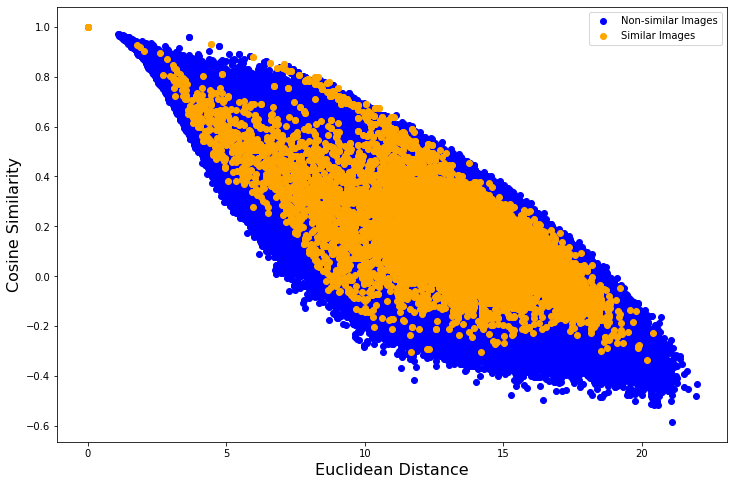

In [114]:
array_full = np.concatenate([array.reshape(-1,1), array_cos.reshape(-1,1)], axis=1)

fig = plt.figure(figsize=(12,8))
plt.scatter(array_full[np.array(y_labels) == 0, 0], array_full[np.array(y_labels) == 0, 1], color='blue', label='Non-similar Images')
plt.scatter(array_full[np.array(y_labels) == 1, 0], array_full[np.array(y_labels) == 1, 1], color='orange', label='Similar Images')
plt.xlabel("Euclidean Distance", fontsize=16)
plt.ylabel("Cosine Similarity", fontsize=16)
plt.legend()
plt.show()

## Using DBSCAN (Clustering)

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

euclidean_embeddings_train = euclidean_distances(embeddings_train)

db = DBSCAN(eps=8.0, min_samples=1, metric='precomputed')
db.fit(euclidean_embeddings_train)

DBSCAN(eps=8.0, metric='precomputed', min_samples=1)

In [28]:
np.unique(db.labels_).shape[0], db.labels_.shape[0]

(4821, 9281)

In [14]:
from sklearn.metrics import homogeneity_score, completeness_score

print(homogeneity_score(labels_train, db.labels_))
completeness_score(labels_train, db.labels_)

0.5630178520511827


0.6110246138833018

In [15]:
label_mapping = {}
for ii, label in enumerate(db.labels_):
    if label not in label_mapping:
        label_mapping[label] = []
    label_mapping[label].append((labels_train[ii], ii))

In [34]:
label_mapping_test = {}
for ii, label in enumerate(labels_test):
    if label not in label_mapping_test:
        label_mapping_test[label] = []
    label_mapping_test[label].append((labels_test[ii], ii))

## Forming groups of Faces

In [16]:
data = pd.DataFrame(columns=['face_id', 'identity', 'cluster_label'])
data_array = []
for cluster_label, mapping in label_mapping.items():
    for (identity, face_id) in mapping:
        data_array.append([face_id, identity, cluster_label])
data = pd.DataFrame(np.array(data_array), columns=['face_id', 'identity', 'cluster_label'])

In [35]:
data_test = pd.DataFrame(columns=['face_id', 'identity'])
data_array = []
for label, mapping in label_mapping_test.items():
    for (identity, face_id) in mapping:
        data_array.append([face_id, identity])
data_test = pd.DataFrame(np.array(data_array), columns=['face_id', 'identity'])

In [17]:
data['face_id'] = data['face_id'].astype(int)
data['cluster_label'] = data['cluster_label'].astype(int)

In [37]:
data_test['face_id'] = data_test['face_id'].astype(int)

In [18]:
data_grouped = data.groupby(by=['identity','cluster_label'], as_index=False).count()

In [19]:
data_grouped = data_grouped.loc[data_grouped['face_id'] > 1]

In [20]:
merge_data = []
for index, row in data_grouped.iterrows():
    merge_data.append(data.loc[(data['identity'] == row['identity']) & (data['cluster_label'] == row['cluster_label'])])

In [21]:
merge_data = pd.concat(merge_data, axis=0)
merge_data.shape

(5031, 3)

In [22]:
data, len(embeddings_train)

(      face_id        identity  cluster_label
 0           0     OrnellaMuti              0
 1           1  Thanasisveggos              0
 2           3      JohnnyCash              0
 3           4    LaurenBacall              0
 4           6  LauraAntonelli              0
 ...       ...             ...            ...
 9276     9266    KevinCostner           4502
 9277     9267    JohnGarfield           4503
 9278     9270    JulieAndrews           4504
 9279     9273   PierceBrosnan           4505
 9280     9275         MegRyan           4506
 
 [9281 rows x 3 columns],
 9281)

In [23]:
np.random.seed(0)
train_merge_data = merge_data.sample(4400)
test_merge_data = merge_data.loc[list(set(merge_data.index.values) - set(train_merge_data.index.values))]

In [24]:
np.unique(merge_data['cluster_label']).shape[0]

274

In [25]:
np.unique(train_merge_data['cluster_label']).shape[0], np.unique(merge_data['cluster_label']).shape[0]

(272, 274)

In [26]:
np.unique(train_merge_data['identity']).shape[0], np.unique(merge_data['identity']).shape[0]

(328, 328)

In [27]:
train_merge_data, labels_train[1456], files_train[1456]

(      face_id          identity  cluster_label
 5289     1456         JohnWayne            792
 1324     3023  TheodorakisMikis              0
 2935     6656         JaneWyman              0
 105       269      WarrenBeatty              0
 1842     4192     RomanPolanski              0
 ...       ...               ...            ...
 2262     5169    HumphreyBogard              0
 4744     8360         RayLiotta            409
 4666     2894        DonJohnson            361
 5295     1462         PeterFalk            797
 3262     7345         JohnWayne              0
 
 [4400 rows x 3 columns],
 'JohnWayne',
 '7201_JohnWayne_68_m.jpg')

In [28]:
test_merge_data, labels_train[4676], files_train[4676]

(      face_id         identity  cluster_label
 2048     4676  MarleneDietrich              0
 4101     9248         campbell              0
 6          12     RichardPryor              0
 2055     4694        MelBrooks              0
 8          15     GladysCooper              0
 ...       ...              ...            ...
 4076     9178       TonyCurtis              0
 2029     4629   AnthonyHopkins              0
 4080     9183       HowardKeel              0
 4088     9203       DebraPaget              0
 4089     9206        MelFerrer              0
 
 [631 rows x 3 columns],
 'MarleneDietrich',
 '14718_MarleneDietrich_34_f.jpg')

In [29]:
train_merge_data.groupby('identity').count()

face_id  cluster_label
identity                              
AbeVigoda            22             22
AdolfHitlerr          9              9
AlanRickman          11             11
AlecGuinness         24             24
AlejandroRey          5              5
...                 ...            ...
ZsaZsaGabor          18             18
angelamerkel         14             14
campbell             12             12
michaeljackson        4              4
motherTereza         16             16

[328 rows x 2 columns]

## Chi-squared Statistics

In [211]:
error_test_merge_data = test_merge_data.groupby(by=['cluster_label', 'identity'], as_index=False).count()
error = [(error_test_merge_data.loc[error_test_merge_data['cluster_label'] == error_test_merge_data.loc[idx, 'cluster_label'], 'face_id'].sum() - \
         error_test_merge_data.loc[idx, 'face_id']) / (error_test_merge_data.loc[error_test_merge_data['cluster_label'] == error_test_merge_data.loc[idx, 'cluster_label'], 'face_id'].sum()) for idx in error_test_merge_data.index]
error_test_merge_data['error'] = error

In [212]:
error_test_merge_data.loc[error_test_merge_data['error'] == 0].shape, error_test_merge_data.loc[error_test_merge_data['error'] != 0].shape

((88, 4), (240, 4))

In [213]:
train_merge_data.groupby('identity').count()

face_id  cluster_label
identity                              
AbeVigoda            22             22
AdolfHitlerr          9              9
AlanRickman          11             11
AlecGuinness         24             24
AlejandroRey          5              5
...                 ...            ...
ZsaZsaGabor          18             18
angelamerkel         14             14
campbell             12             12
michaeljackson        4              4
motherTereza         16             16

[328 rows x 2 columns]

In [214]:
error_test_merge_data['error'].mean()

0.7286585365853658

In [23]:
embeddings_merge_train = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in train_merge_data['face_id'].values]
embeddings_merge_test = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in test_merge_data['face_id'].values]

In [24]:
embeddings_merge_train = tf.concat(embeddings_merge_train, 0)
embeddings_merge_test = tf.concat(embeddings_merge_test, 0)

In [217]:
svm_grouped = SVC(kernel='linear')
svm_grouped.fit(embeddings_merge_train.numpy(), train_merge_data['cluster_label'])

SVC(kernel='linear')

In [218]:
accuracy_score(test_merge_data['cluster_label'], svm_grouped.predict(embeddings_merge_test))

0.9873217115689382

In [42]:
faces_identified = {}
for ii, label in enumerate(db.labels_):
    if labels_train[ii] not in faces_identified:
        faces_identified[labels_train[ii]] = []
    faces_identified[labels_train[ii]].append(label)

In [48]:
db.core_sample_indices_

array([   0,    1,    2, ..., 9278, 9279, 9280], dtype=int64)

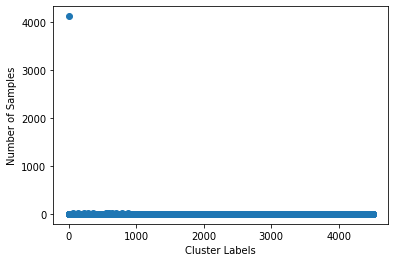

In [6]:
from collections import Counter

plt.scatter(dict(Counter(db.labels_)).keys(), dict(Counter(db.labels_)).values())
plt.xlabel("Cluster Labels")
plt.ylabel("Number of Samples")
plt.show()

In [219]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(test_merge_data['cluster_label'], svm_grouped.predict(embeddings_merge_test), average='micro')

0.9873217115689382

<AxesSubplot:>

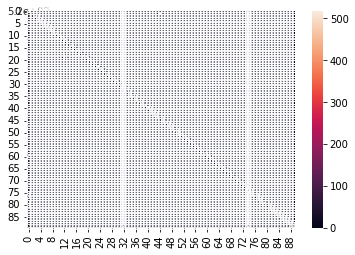

In [203]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(test_merge_data['cluster_label'], svm_grouped.predict(embeddings_merge_test)), annot=True)

In [237]:
len(test_merge_data['cluster_label']), len(train_merge_data['cluster_label'])

(531, 4500)

## Ensemble of DBSCAN

In [88]:
db

DBSCAN(eps=8.0, metric='precomputed', min_samples=1)

In [98]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [90]:
np.unique(labels_train).shape

(331,)

In [92]:
np.unique(labels_test).shape

(318,)

In [115]:
established_stream_distances = euclidean_distances(embeddings_test, embeddings_test)

In [116]:
established_stream_distances.shape

(1032, 1032)

In [117]:
established_stream_cosine = cosine_similarity(embeddings_test, embeddings_test)

In [250]:
db_new = DBSCAN(eps=2.0, min_samples=1, metric='precomputed')
db_new.fit(established_stream_distances)

DBSCAN(eps=2.0, metric='precomputed', min_samples=1)

In [251]:
Counter(db_new.labels_)

Counter({0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 65,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 1,
 

In [123]:
label_mapping_test = {}
for ii, label in enumerate(db_new.labels_):
    if label not in label_mapping_test:
        label_mapping_test[label] = []
    label_mapping_test[label].append((labels_test[ii], ii))

In [124]:
data_tst = pd.DataFrame(columns=['face_id', 'identity', 'cluster_label'])
data_array = []
for cluster_label, mapping in label_mapping_test.items():
    for (identity, face_id) in mapping:
        data_array.append([face_id, identity, cluster_label])
data_test = pd.DataFrame(np.array(data_array), columns=['face_id', 'identity', 'cluster_label'])

In [125]:
data_test['face_id'] = data_test['face_id'].astype(int)
data_test['cluster_label'] = data_test['cluster_label'].astype(int)

In [127]:
data_grouped_test = data_test.groupby(by=['identity','cluster_label'], as_index=False).count()

In [129]:
data_test.groupby(by=['cluster_label'], as_index=False).count()

cluster_label  face_id  identity
0                0        1         1
1                1        1         1
2                2        1         1
3                3        1         1
4                4      411       411
..             ...      ...       ...
591            591        1         1
592            592        1         1
593            593        1         1
594            594        1         1
595            595        1         1

[596 rows x 3 columns]

In [136]:
y_pred_test = svm_grouped.predict(embeddings_test)
unique_labels = np.unique(y_pred_test)

In [220]:
identities_test_from_svm = []
for label in unique_labels:
    identities_test_from_svm.append(merge_data.loc[merge_data['cluster_label'] == label, 'identity'].values.tolist())

In [221]:
np.array(identities_test_from_svm)[np.array(identities_test_from_svm) == 'AbeVigoda']

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([], dtype=object)

In [143]:
y_pred_test

array([  0,   0, 290, ...,   0,   0, 486])

In [225]:
labels_test[10], identities_test_from_svm[10]

('AlecGuinness', ['StevenBerkoff', 'StevenBerkoff'])

## Feature Selection

In [41]:
train_cluster_label_0 = train_merge_data.loc[train_merge_data['cluster_label'] == 0]
test_cluster_label_0 = test_merge_data.loc[test_merge_data['cluster_label'] == 0]

train_embeddings_cluster_label_0 = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in train_cluster_label_0['face_id'].values]
test_embeddings_cluster_label_0 = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in test_cluster_label_0['face_id'].values]

train_embeddings_cluster_label_0 = tf.concat(train_embeddings_cluster_label_0, 0)
test_embeddings_cluster_label_0 = tf.concat(test_embeddings_cluster_label_0, 0)

In [44]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

embeddings_cluster_label_0 = euclidean_distances(np.vstack([train_embeddings_cluster_label_0.numpy(), test_embeddings_cluster_label_0.numpy()]))

In [42]:
full_cluster_label_0 = pd.concat([train_cluster_label_0, test_cluster_label_0], axis=0)

In [45]:
db_cluster_label_0 = DBSCAN(eps=20.0, min_samples=1)
db_cluster_label_0.fit(embeddings_cluster_label_0)

DBSCAN(eps=20.0, min_samples=1)

In [46]:
db_cluster_label_0.labels_.shape[0], np.unique(db_cluster_label_0.labels_).shape[0]

(4112, 3430)

In [47]:
np.unique(db_cluster_label_0.labels_)

array([   0,    1,    2, ..., 3427, 3428, 3429], dtype=int64)

In [48]:
from sklearn.metrics import homogeneity_score, completeness_score

full_cluster_label_0 = pd.concat([train_cluster_label_0, test_cluster_label_0], axis=0)

print(homogeneity_score(full_cluster_label_0['identity'], db_cluster_label_0.labels_))
completeness_score(full_cluster_label_0['identity'], db_cluster_label_0.labels_)

0.8592764355387463


0.6627924313091367

In [49]:
np.unique(full_cluster_label_0['identity']).shape, np.unique(train_cluster_label_0['identity']).shape, np.unique(test_cluster_label_0['identity']).shape

((327,), (327,), (240,))

In [50]:
full_cluster_label_0['cluster_label'] = db_cluster_label_0.labels_

In [51]:
train_cluster_label_0.shape[0], test_cluster_label_0.shape[0]

(3594, 518)

In [52]:
full_cluster_label_0.groupby(by=['identity']).count()

face_id  cluster_label
identity                              
AbeVigoda            15             15
AdolfHitlerr         11             11
AlanRickman           9              9
AlecGuinness         22             22
AlejandroRey          4              4
...                 ...            ...
ZsaZsaGabor          15             15
angelamerkel          5              5
campbell             10             10
michaeljackson        6              6
motherTereza          8              8

[327 rows x 2 columns]

## Feature Selection by IG

In [46]:
def entropy(P):
    return -(P * np.log(P)).sum()

def entropy_axis(data):
    return -(data * np.log(data)).sum(axis=0)

def mutual_information(cluster_labels, label, data):
    P = data[cluster_labels==label] + 5
    return - sum(cluster_labels == label) / len(cluster_labels) * entropy_axis(P)

In [47]:
embeddings_train.numpy().max(), embeddings_train.numpy().min()

(4.626772, -4.6210995)

In [56]:
features = [embeddings_train.numpy()[:, i] + 5 for i in tqdm(range(embeddings_train.shape[1]))]
mutual_information_array = [mutual_information(db.labels_, label, embeddings_train.numpy()) for label in tqdm(np.unique(db.labels_))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4507/4507 [01:52<00:00, 40.22it/s]


In [57]:
np.vstack(mutual_information_array).shape

(4507, 128)

In [58]:
mutual_information_array = np.vstack(mutual_information_array)
mutual_information_array = mutual_information_array.mean(axis=0)

In [59]:
mutual_information_array.shape

(128,)

In [60]:
information_gain = [entropy(features[i]) - mutual_information_array[i] for i in tqdm(range(len(features)))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 24246.72it/s]


In [61]:
mutual_information_array

array([2.7775726, 3.032874 , 3.4760098, 3.0512474, 3.9716747, 3.7112856,
       3.573579 , 3.2807753, 3.327433 , 3.6876001, 4.028128 , 3.1706395,
       3.19636  , 2.8539653, 2.8705554, 3.6723537, 3.4445744, 3.2756367,
       3.4726653, 2.6039407, 3.0894022, 3.4322727, 3.065615 , 3.3837276,
       3.2382324, 3.2453215, 3.789803 , 3.6280615, 2.6649086, 3.0894647,
       3.1894205, 3.5640676, 3.2612295, 3.0430305, 3.8962243, 3.154968 ,
       3.25673  , 3.513511 , 3.6928377, 3.411652 , 3.4419184, 3.101737 ,
       3.1620004, 3.596892 , 2.800521 , 2.6809647, 3.6058288, 3.1104858,
       3.731791 , 3.5704565, 2.6747322, 3.9957917, 3.6438925, 3.047174 ,
       3.803621 , 3.698056 , 3.2552912, 3.4097617, 2.9795823, 2.6645846,
       3.1802897, 2.8926258, 3.2897034, 3.7507353, 3.676077 , 3.865393 ,
       3.057576 , 4.113641 , 3.3824983, 3.3375525, 2.940091 , 3.2156928,
       3.4860651, 3.2932916, 2.9658005, 3.3161438, 3.035497 , 3.671689 ,
       2.986146 , 3.5425396, 2.784761 , 2.794177 , 

In [62]:
np.argsort(information_gain)

array([ 67,  94,   4, 115,  10,  51,  65,  43, 112, 119,  54,  77,   9,
       126,  85, 124,  73,  48, 113, 101,   7,  46,  31, 111,  34,   5,
        63,  27,  75,  89,  26,  68,  90,  79, 118, 127,  18,  69,  15,
        37,  86,   2,  11,  57,  83,  52, 121,  21,  64,  95,  40, 123,
        23,  56,  84,  16,   6,  49,  71, 106,  25,  97, 122,  62,  38,
       104, 105,  36, 110, 108, 116,  17,  39,  20,   8,   1,  92,  12,
        41,  42,  32,  22,  55,  72,  74,  91,  78,  60,  82,  30,  24,
        98,  76,  66,  13,  33,  35,  93,  61, 114,  53, 117,  47,  81,
       107,  28,  87,   3,  29, 109,  70,  96, 125,  19,  14,  58,  99,
       102,  88, 103,   0,  80,  59,  50, 100, 120,  44,  45], dtype=int64)

In [63]:
new_reduced_embeddings_train_cluster_label_0 = embeddings_cluster_label_0[:, np.argsort(information_gain)[:51]]

In [64]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

new_euclidean_embeddings_train = euclidean_distances(new_reduced_embeddings_train_cluster_label_0)

db_new = DBSCAN(eps=2.49, min_samples=1, metric='precomputed')
db_new.fit(new_euclidean_embeddings_train)

DBSCAN(eps=2.49, metric='precomputed', min_samples=1)

In [65]:
np.unique(db_new.labels_).shape, db_new.labels_[db_new.labels_==0].shape, db_new.labels_[db_new.labels_==1].shape, db_new.labels_.shape

((3230,), (1,), (2,), (4112,))

In [66]:
np.unique(db.labels_).shape, db.labels_[db.labels_==0].shape, db.labels_[db.labels_==1].shape

((4507,), (4115,), (1,))

In [67]:
train_cluster_label_0.shape, test_cluster_label_0.shape

((3594, 3), (518, 3))

In [68]:
full_cluster_label_0['cluster_label'] = db_new.labels_

In [61]:
full_cluster_label_0

face_id          identity  cluster_label
1324     3023  TheodorakisMikis              0
2935     6656         JaneWyman              1
105       269      WarrenBeatty              2
1842     4192     RomanPolanski              3
699      1651  DanielleDarrieux              4
...       ...               ...            ...
4076     9178        TonyCurtis              6
2029     4629    AnthonyHopkins           3427
4080     9183        HowardKeel           3428
4088     9203        DebraPaget           3429
4089     9206         MelFerrer              6

[4112 rows x 3 columns]

In [60]:
full_cluster_label_0.groupby('identity').count()[full_cluster_label_0.groupby('identity').count()['face_id'] > 1]

face_id  cluster_label
identity                              
AbeVigoda            15             15
AdolfHitlerr         11             11
AlanRickman           9              9
AlecGuinness         22             22
AlejandroRey          4              4
...                 ...            ...
ZsaZsaGabor          15             15
angelamerkel          5              5
campbell             10             10
michaeljackson        6              6
motherTereza          8              8

[327 rows x 2 columns]

In [57]:
np.random.seed(0)
train_full_cluster_label_0 = full_cluster_label_0.sample(3400)
test_full_cluster_label_0 = full_cluster_label_0.loc[list(set(full_cluster_label_0.index.values) - set(train_full_cluster_label_0.index.values))]

In [58]:
np.unique(train_full_cluster_label_0['identity']).shape, np.unique(full_cluster_label_0['identity']).shape

((327,), (327,))

In [59]:
train_full_cluster_label_0.groupby('identity').count()

face_id  cluster_label
identity                              
AbeVigoda            13             13
AdolfHitlerr          8              8
AlanRickman           8              8
AlecGuinness         19             19
AlejandroRey          2              2
...                 ...            ...
ZsaZsaGabor          10             10
angelamerkel          4              4
campbell              9              9
michaeljackson        5              5
motherTereza          8              8

[327 rows x 2 columns]

## SVM Eigen faces Classification

In [53]:
full_cluster_label_0, files_train[3023], labels_train[3023]

(      face_id          identity  cluster_label
 1324     3023  TheodorakisMikis              0
 2935     6656         JaneWyman              1
 105       269      WarrenBeatty              2
 1842     4192     RomanPolanski              3
 699      1651  DanielleDarrieux              4
 ...       ...               ...            ...
 4076     9178        TonyCurtis              6
 2029     4629    AnthonyHopkins           3427
 4080     9183        HowardKeel           3428
 4088     9203        DebraPaget           3429
 4089     9206         MelFerrer              6
 
 [4112 rows x 3 columns],
 '235_TheodorakisMikis_31_m.jpg',
 'TheodorakisMikis')

In [54]:
embeddings_train.shape

TensorShape([9281, 128])

In [319]:
!git clone https://github.com/lab-cosmo/scikit-cosmo

Cloning into 'scikit-cosmo'...


In [52]:
sys.path.append("./scikit-cosmo")

In [62]:
train_full_embeddings_cluster_label_0 = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in train_full_cluster_label_0['face_id'].values]
test_full_embeddings_cluster_label_0 = [tf.expand_dims(embeddings_train[face_id], 0) for face_id in test_full_cluster_label_0['face_id'].values]

train_full_embeddings_cluster_label_0 = tf.concat(train_full_embeddings_cluster_label_0, 0)
test_full_embeddings_cluster_label_0 = tf.concat(test_full_embeddings_cluster_label_0, 0)

In [63]:
full_cluster_label_0 = pd.concat([train_full_cluster_label_0, test_full_cluster_label_0], axis=0)
idx = dict(zip(np.unique(full_cluster_label_0['identity']).tolist(), list(range(len(np.unique(full_cluster_label_0['identity']))))))
classes = [idx[identity] for identity in full_cluster_label_0['identity']]

In [65]:
import cv2
from collections import OrderedDict

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image

def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size))
    for i in range(nrof_samples):
        img = imageio.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
#         img = crop(img, do_random_crop, image_size)
        img = cv2.resize(img, (image_size,image_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        images[i,:,:] = img
    return images

faces = OrderedDict({})
files_valid = []
file_train_classes = []
for ii, file_train in tqdm(enumerate(np.array(files_train)[full_cluster_label_0['face_id'].values.tolist()])):
    image = load_data([os.path.join(DATADIR, "AgeDB", file_train)], False, False, 64)
    faces[file_train] = image
    files_valid.append(file_train)
    file_train_classes.append(file_train.split("_")[1])

4112it [02:54, 23.61it/s]


In [66]:
faces_np = np.vstack(list(faces.values()))

In [67]:
faces_np.shape

(4112, 64, 64)

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform

X_train, X_test, y_train, y_test = train_test_split(faces.reshape(-1,4096), classes, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=150, svd_solver="randomized", whiten=True)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
P = pca.components_.T
P.shape

(4096, 150)

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}

svm_faces = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
svm_faces.fit(X_pca_train, y_train)
print("Best estimator found by grid search:")
print(svm_faces.best_estimator_)

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Best estimator found by grid search:
SVC(C=16776.33185955907, class_weight='balanced', gamma=0.0038232531131348717)


In [72]:
len(y_train), len(y_test)

(3084, 1028)

In [80]:
y_pred = svm_faces.predict(X_pca_test)

In [81]:
accuracy_score(y_test, y_pred)

0.0632295719844358

## Dividing the classes into classes containing small size

In [82]:
np.unique(y_train).shape[0], np.unique(y_test).shape[0]

(327, 301)

In [90]:
np.unique(classes).shape[0], len(classes)

(327, 4112)

In [72]:
from collections import Counter, OrderedDict

counter_classes = OrderedDict(dict(Counter(full_cluster_label_0['identity'])))
counter_classes

OrderedDict([('Pele', 14),
             ('ClaudetteColbert', 19),
             ('NormaShearer', 15),
             ('FlemingAlex', 9),
             ('michaeljackson', 6),
             ('LorettaYoung', 28),
             ('CaryGrant', 21),
             ('MartinSheen', 7),
             ('EdwardGRobinson', 22),
             ('JoanLeslie', 11),
             ('ScottGlenn', 17),
             ('SylvesterStallone', 6),
             ('StevenBerkoff', 11),
             ('AnnMiller', 33),
             ('DirkBogarde', 17),
             ('RobertRyan', 14),
             ('CatherineDeneuve', 5),
             ('GordonThomson', 9),
             ('JessicaTandy', 18),
             ('MurrayHamilton', 10),
             ('PatriciaNeal', 20),
             ('MarlonBrando', 13),
             ('TonyCurtis', 14),
             ('MyrnaLoy', 37),
             ('JuneAllyson', 16),
             ('JohnWayne', 8),
             ('SamElliott', 15),
             ('OrnellaMuti', 19),
             ('JaneAsher', 13),
         

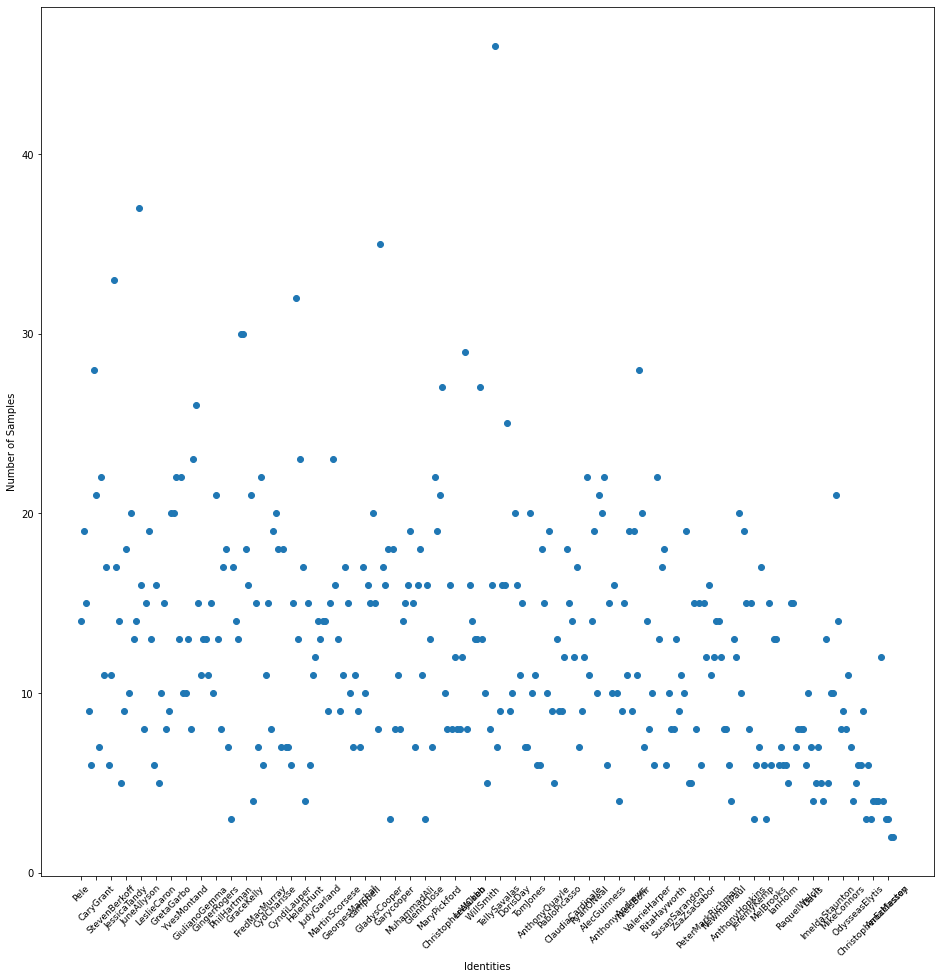

In [73]:
fig = plt.figure(figsize=(16,16))
plt.scatter(dict(counter_classes).keys(), dict(counter_classes).values())
plt.xlabel("Identities")
plt.ylabel("Number of Samples")
plt.xticks(list(dict(counter_classes).keys())[::6], rotation=45, fontsize=9)
plt.show()

In [74]:
len(classes)

4112

In [75]:
len(files_valid)

4112

In [222]:
files_classes = dict(zip(classes, files_valid))

In [76]:
full_cluster_label_0['files_valid'] = files_valid
full_cluster_label_0

face_id          identity  cluster_label  \
3316     7449              Pele           2860   
4056     9141  ClaudetteColbert            333   
2113     4818      NormaShearer            198   
66        157       FlemingAlex           2723   
338       784    michaeljackson           3062   
...       ...               ...            ...   
2025     4622      RonaldReagan           1220   
4079     9182        JanePowell           2296   
2040     4656       LuiseRainer           2594   
4091     9214      GenaRowlands           2089   
2047     4674         NickNolte              6   

                          files_valid  
3316                 54_Pele_30_m.jpg  
4056  14670_ClaudetteColbert_37_f.jpg  
2113      13705_NormaShearer_35_f.jpg  
66          1069_FlemingAlex_74_m.jpg  
338       267_michaeljackson_44_m.jpg  
...                               ...  
2025        740_RonaldReagan_54_m.jpg  
4079        15370_JanePowell_15_f.jpg  
2040       10638_LuiseRainer_26_f.jpg  
4091       4125_GenaRowlands_29_m.jpg  
2047          2184_NickNolte_34_m.jpg  

[4112 rows x 4 columns]

In [437]:
from copy import copy

copy_classes = copy(classes)
faces_chunk = []
faces_chunk_array = []
face_classes = []
face_classes_array = []
for name, counter_class in tqdm(dict(Counter(file_train_classes)).items()):
    df = full_cluster_label_0[
        full_cluster_label_0['identity'] == name
    ]
    for idx, row in df.iterrows():
        faces_chunk.append(faces[row['files_valid']].reshape(4096))
        face_classes.append(name)
    face_classes_array.append(face_classes)
    faces_chunk_array.append(faces_chunk)
    faces_chunk = []
    face_classes = []

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 808.69it/s]


In [350]:
files_test

['2327_AbeVigoda_52_m.jpg',
 '2336_AbeVigoda_61_m.jpg',
 '2347_AbeVigoda_76_m.jpg',
 '2352_AbeVigoda_85_m.jpg',
 '771_AdolfHitlerr_44_m.jpg',
 '773_AdolfHitlerr_36_m.jpg',
 '3015_AlanRickman_45_m.jpg',
 '3017_AlanRickman_48_m.jpg',
 '3028_AlanRickman_62_m.jpg',
 '8747_AlecGuinness_32_m.jpg',
 '8759_AlecGuinness_45_m.jpg',
 '8498_AlejandroRey_38_m.jpg',
 '8507_AlejandroRey_45_m.jpg',
 '1253_AlexanderGrahamBell_29_m.jpg',
 '1260_AlexanderGrahamBell_29_m.jpg',
 '9936_AliMacGraw_60_f.jpg',
 '9941_AliMacGraw_70_f.jpg',
 '9945_AliMacGraw_74_f.jpg',
 '1249_AndreMarieAmpКre_30_m.jpg',
 '7791_AndyGriffith_38_m.jpg',
 '7801_AndyGriffith_50_m.jpg',
 '7802_AndyGriffith_51_m.jpg',
 '7818_AndyGriffith_79_m.jpg',
 '11950_AngelaLansbury_23_f.jpg',
 '11988_AngelaLansbury_85_f.jpg',
 '12417_AngieDickinson_29_f.jpg',
 '12423_AngieDickinson_44_f.jpg',
 '12424_AngieDickinson_45_f.jpg',
 '12454_AngieDickinson_58_f.jpg',
 '14978_AnnJillian_24_f.jpg',
 '14985_AnnJillian_35_f.jpg',
 '14989_AnnJillian_40_f.jpg'

In [68]:
np.random.seed(1000)
files_train_df = merged_sample.sample(int(0.9*10313))
files_test_df = merged_sample.loc[list(set(merged_sample.index.values) - set(files_train_df.index.values))]

In [69]:
import cv2

def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size))
    for i in range(nrof_samples):
        img = imageio.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
#         img = crop(img, do_random_crop, image_size)
        img = cv2.resize(img, (image_size,image_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        images[i,:,:] = img
    return images

faces_test = OrderedDict({})
file_new_classes = []
for idx, row in tqdm(files_test_df.iterrows()):
    if row['name'] in file_train_classes:
        image = load_data([os.path.join(DATADIR, "AgeDB", row['filename'])], False, False, 64)
        faces_test[row['filename']] = image
        file_new_classes.append(row['name'])

1032it [00:31, 32.51it/s]


In [70]:
np.unique(file_train_classes).shape, np.unique(file_new_classes).shape

((327,), (314,))

In [77]:
Counter(file_train_classes)

Counter({'Pele': 14,
         'ClaudetteColbert': 19,
         'NormaShearer': 15,
         'FlemingAlex': 9,
         'michaeljackson': 6,
         'LorettaYoung': 28,
         'CaryGrant': 21,
         'MartinSheen': 7,
         'EdwardGRobinson': 22,
         'JoanLeslie': 11,
         'ScottGlenn': 17,
         'SylvesterStallone': 6,
         'StevenBerkoff': 11,
         'AnnMiller': 33,
         'DirkBogarde': 17,
         'RobertRyan': 14,
         'CatherineDeneuve': 5,
         'GordonThomson': 9,
         'JessicaTandy': 18,
         'MurrayHamilton': 10,
         'PatriciaNeal': 20,
         'MarlonBrando': 13,
         'TonyCurtis': 14,
         'MyrnaLoy': 37,
         'JuneAllyson': 16,
         'JohnWayne': 8,
         'SamElliott': 15,
         'OrnellaMuti': 19,
         'JaneAsher': 13,
         'NicolasSarkozy': 6,
         'LeslieCaron': 16,
         'KostasVoutsas': 5,
         'RobertRedford': 10,
         'JonVoight': 15,
         'ErnestBorgnine': 8,
         '

In [78]:
from copy import copy

copy_classes = copy(file_train_classes)
faces_chunk = []
faces_chunk_array = []
face_classes = []
face_classes_array = []
for name, counter_class in tqdm(dict(Counter(file_train_classes)).items()):
    df = full_cluster_label_0[
        full_cluster_label_0['identity'] == name
    ]
    for idx, row in df.iterrows():
        faces_chunk.append(faces[row['files_valid']].reshape(4096))
        face_classes.append(name)
    face_classes_array.append(face_classes)
    faces_chunk_array.append(faces_chunk)
    faces_chunk = []
    face_classes = []

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:00<00:00, 768.11it/s]


In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

svm_faces_array = []
rf_array = []
hist_array = []
knn_array = []
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
param_grid2 = {
    "criterion": ['entropy', 'gini'], 
    "min_samples_split": [2,5,10]
}
param_grid3 = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_iter": [50, 100, 200],
    "max_depth": [3, 5, 10], 
    "min_samples_leaf": [1, 5, 10, 20]
}
score_svm = []
score_hist = []
score_rf = []
score = []
faces_test_data = np.stack(list(faces_test.values())).reshape(-1,4096)
for i in tqdm(range(len(face_classes_array)//3)):
    face_classes = np.concatenate(face_classes_array[i*3:i*3+3])
    np.random.seed(100)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    face_classes_train = face_classes[idx[:int(0.7*len(face_classes))]]
    faces_data = np.vstack(faces_chunk_array[i*3:i*3+3])
    faces_data_train = faces_data[idx[:int(0.7*len(face_classes))]]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(faces_data_train)
    pca = PCA(n_components=X_train.shape[0]-1)
    X_pca_train = pca.fit_transform(X_train)
    
    svm_faces = RandomizedSearchCV(
        SVC(kernel="rbf", class_weight="balanced", probability=True), param_grid, n_iter=10, cv=2
    )
    rf = RandomizedSearchCV(RandomForestClassifier(), param_grid2, n_iter=10, cv=2)
    hist = RandomizedSearchCV(HistGradientBoostingClassifier(), param_grid3, n_iter=10, cv=2)
    knn = KNeighborsClassifier(n_neighbors=4)
    
    voting_classifier = VotingClassifier(estimators=[
        ('svm', svm_faces), ('rf', rf), ('hist', hist), ('knn', knn)
    ], voting='soft')
    
    voting_classifier.fit(X_pca_train, face_classes_train)
    
    face_classes_test = face_classes[idx[int(0.7*len(face_classes)):]]
    faces_data_test = faces_data[idx[int(0.7*len(face_classes)):]]
    
    X_test = scaler.transform(faces_data_test)
    X_pca_test = pca.transform(X_test)
    
    svm_faces_array.append(voting_classifier.named_estimators_.svm)
    rf_array.append(voting_classifier.named_estimators_.rf)
    hist_array.append(voting_classifier.named_estimators_.hist)
    knn_array.append(knn)
    score.append(accuracy_score(face_classes_test, voting_classifier.predict(X_pca_test)))

  0%|                                                                                                                    | 0/109 [00:00<?, ?it/s]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  1%|▉                                                                                                           | 1/109 [00:06<11:18,  6.28s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  2%|█▉                                                                                                          | 2/109 [00:11<10:16,  5.76s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 19%|████████████████████▌                                                                                      | 21/109 [02:16<08:32,  5.83s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 20%|█████████████████████▌                                                                                     | 22/109 [02:26<10:13,  7.05s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 21%|██████████████████████▌                                                                                    | 23/109 [02:35<11:04,  7.73s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 39%|█████████████████████████████████████████▏                                                                 | 42/109 [04:31<07:50,  7.02s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 39%|██████████████████████████████████████████▏                                                                | 43/109 [04:37<07:19,  6.66s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 40%|███████████████████████████████████████████▏                                                               | 44/109 [04:43<07:09,  6.61s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 58%|█████████████████████████████████████████████████████████████▊                                             | 63/109 [07:06<05:33,  7.25s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 59%|██████████████████████████████████████████████████████████████▊                                            | 64/109 [07:12<05:18,  7.09s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 60%|███████████████████████████████████████████████████████████████▊                                           | 65/109 [07:19<05:06,  6.97s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 84/109 [09:38<02:57,  7.09s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 85/109 [09:46<02:51,  7.15s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 86/109 [09:54<02:54,  7.60s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 105/109 [11:44<00:20,  5.10s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 106/109 [11:49<00:14,  4.98s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 107/109 [11:54<00:09,  4.94s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

In [116]:
score

[0.8,
 0.6153846153846154,
 0.6,
 0.45454545454545453,
 0.7894736842105263,
 0.5555555555555556,
 0.4,
 0.65,
 0.6666666666666666,
 0.4166666666666667,
 0.4,
 0.5,
 0.2631578947368421,
 0.42857142857142855,
 0.7,
 0.65,
 0.5,
 0.45454545454545453,
 0.5384615384615384,
 0.3076923076923077,
 0.6363636363636364,
 0.6818181818181818,
 0.6470588235294118,
 0.625,
 0.5833333333333334,
 0.23076923076923078,
 0.7142857142857143,
 0.7,
 0.6875,
 0.625,
 0.75,
 0.5,
 0.46153846153846156,
 0.6666666666666666,
 0.4166666666666667,
 0.6923076923076923,
 0.4444444444444444,
 0.4,
 0.6153846153846154,
 0.38461538461538464,
 0.7142857142857143,
 0.5833333333333334,
 0.3333333333333333,
 0.5714285714285714,
 0.8461538461538461,
 0.5714285714285714,
 0.9,
 0.7333333333333333,
 0.5555555555555556,
 0.6,
 0.4444444444444444,
 0.6,
 0.46153846153846156,
 0.5625,
 0.8571428571428571,
 0.6190476190476191,
 0.3076923076923077,
 0.6428571428571429,
 0.4666666666666667,
 0.4444444444444444,
 0.46153846153846156

In [117]:
np.array(score).mean(), pd.Series(score).sem()

(0.5557206283379346, 0.015818337604740995)

In [90]:
svm_faces_array[0].best_estimator_

SVC(C=5806.131796436875, class_weight='balanced', gamma=0.00012865544455028459)

In [91]:
svm_array = [svm_cv.best_estimator_ for svm_cv in svm_faces_array]
rf_array = [rf_cv.best_estimator_ for rf_cv in rf_array]
h_array = [hist.best_estimator_ for hist in hist_array]

In [161]:
score_svm = []
score_rf = []
score_hist = []
score_knn = []
face_classes_count = 0
for i in tqdm(range(len(face_classes_array)//3)):
    face_classes = np.concatenate(face_classes_array[i*3:i*3+3])
    np.random.seed(100)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    face_classes_train = face_classes[idx[:int(0.7*len(face_classes))]]
    faces_data = np.vstack(faces_chunk_array[i*3:i*3+3])
    faces_data_train = faces_data[idx[:int(0.7*len(face_classes))]]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(faces_data_train)
    pca = PCA(n_components=X_train.shape[0]-1)
    X_pca_train = pca.fit_transform(X_train)
    
    svm_array[i].fit(X_pca_train, face_classes_train)
    rf_array[i].fit(X_pca_train, face_classes_train)
    h_array[i].fit(X_pca_train, face_classes_train)
    knn_array[i].fit(X_pca_train, face_classes_train)
    
    face_classes_test = face_classes[idx[int(0.7*len(face_classes)):]]
    faces_data_test = faces_data[idx[int(0.7*len(face_classes)):]]
    
    X_test = scaler.transform(faces_data_test)
    X_pca_test = pca.transform(X_test)
    
    score_svm.append(accuracy_score(face_classes_test, svm_array[i].predict(X_pca_test)) * len(face_classes))
    score_rf.append(accuracy_score(face_classes_test, rf_array[i].predict(X_pca_test)) * len(face_classes))
    score_hist.append(accuracy_score(face_classes_test, h_array[i].predict(X_pca_test)) * len(face_classes))
    score_knn.append(accuracy_score(face_classes_test, knn_array[i].predict(X_pca_test)) * len(face_classes))
    face_classes_count += len(face_classes)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [01:08<00:00,  1.59it/s]


In [163]:
(np.array(score_svm) / face_classes_count).sum()

0.5824749358770641

In [164]:
(np.array(score_hist) / face_classes_count).sum()

0.5119323080710069

In [165]:
(np.array(score_rf) / face_classes_count).sum()

0.5463555942247583

In [166]:
(np.array(score_knn) / face_classes_count).sum()

0.5201799444638308

In [169]:
scores = np.stack([score_svm, score_hist, score_rf, score_knn]) / face_classes_count
scores.shape

(4, 109)

In [172]:
np.array(scores).max(axis=0).sum(), pd.DataFrame(np.array(scores).max(axis=0)).sem() * np.sqrt(len(scores))

(0.6336875996049272,
 0    0.000485
 dtype: float64)

In [157]:
c_array = [svm_model.C for svm_model in svm_array]
split = [rf_model.min_samples_split for rf_model in rf_array]
depth = [hist_model.max_depth for hist_model in h_array]
leaf = [hist_model.min_samples_leaf for hist_model in h_array]
max_iter = [hist_model.max_iter for hist_model in h_array]
lr = [hist_model.learning_rate for hist_model in h_array]
criterion = [rf_model.criterion for rf_model in rf_array]

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


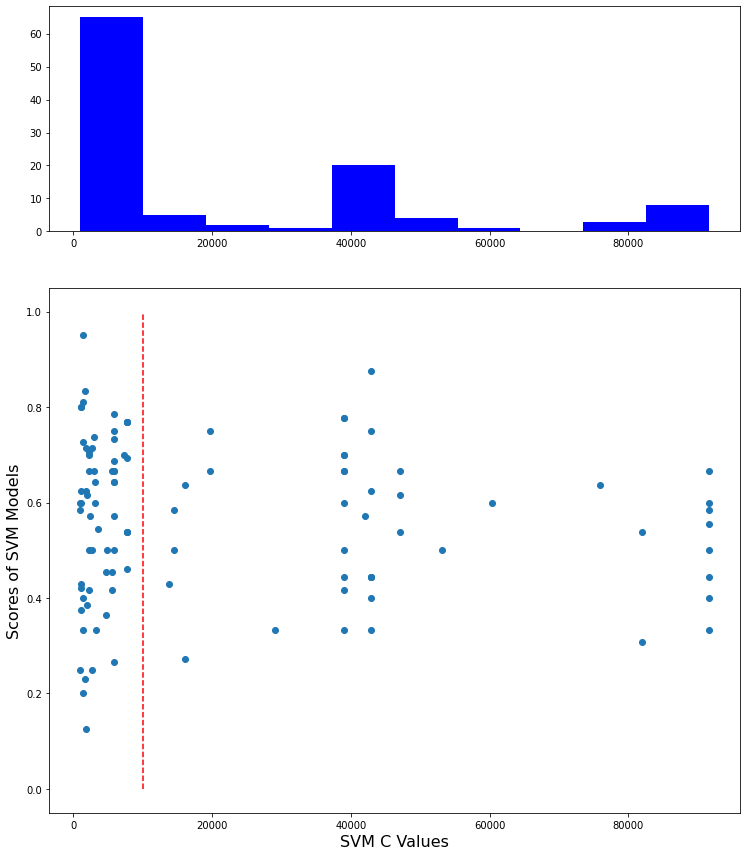

In [134]:
# start with a square Figure
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

ax_0_0.scatter(c_array, score_svm)
ax_0_0.vlines(x=10000, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("SVM C Values", fontsize=16)
ax_0_0.set_ylabel("Scores of SVM Models", fontsize=16)

ax1_histx.hist(c_array, color='blue')
fig.show()

In [155]:
RESULT_C = ((np.array(c_array)[np.array(c_array) < 10000]) * np.array(score_svm)[np.array(c_array) < 10000]).sum() / np.array(score_svm)[np.array(c_array) < 10000].sum()
RESULT_C

3887.783057567878

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


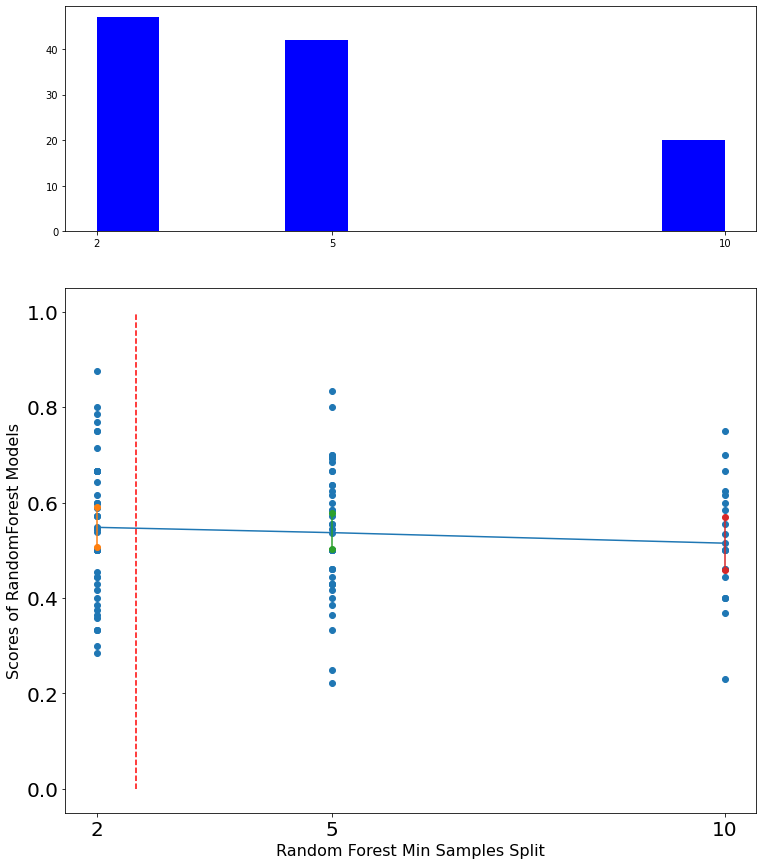

In [150]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

ax_0_0.scatter(split, score_rf)
ax_0_0.vlines(x=2.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Random Forest Min Samples Split", fontsize=16)
ax_0_0.set_ylabel("Scores of RandomForest Models", fontsize=16)

ax1_histx.hist(split, color='blue')

score_rf = np.array(score_rf)
split = np.array(split)

ax_0_0.plot(np.array([2, 5, 10]), 
        np.array([score_rf[split==2].mean(), score_rf[split==5].mean(), score_rf[split==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([2, 2]), 
        np.array([score_rf[split==2].mean()-1.96*pd.Series(score_rf[split==2]).sem(), score_rf[split==2].mean()+1.96*pd.Series(score_rf[split==2]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_rf[split==5].mean()-1.96*pd.Series(score_rf[depth==5]).sem(), score_rf[split==5].mean()+1.96*pd.Series(score_rf[split==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_rf[split==10].mean()-1.96*pd.Series(score_rf[split==10]).sem(), score_rf[split==10].mean()+1.96*pd.Series(score_rf[split==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([2, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


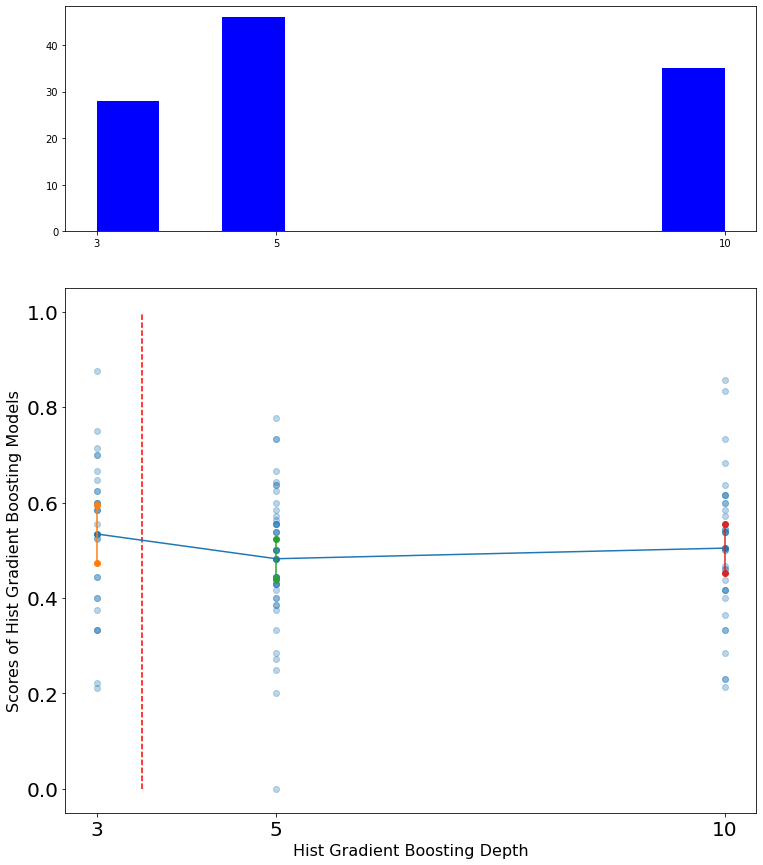

In [143]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

ax_0_0.scatter(depth, score_hist, alpha=0.3)
ax_0_0.vlines(x=3.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Depth", fontsize=16)
ax_0_0.set_ylabel("Scores of Hist Gradient Boosting Models", fontsize=16)

ax1_histx.hist(depth, color='blue')

score_hist = np.array(score_hist)
depth = np.array(depth)

ax_0_0.plot(np.array([3, 5, 10]), 
        np.array([score_hist[depth==3].mean(), score_hist[depth==5].mean(), score_hist[depth==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([3, 3]), 
        np.array([score_hist[depth==3].mean()-1.96*pd.Series(score_hist[depth==3]).sem(), score_hist[depth==3].mean()+1.96*pd.Series(score_hist[depth==3]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_hist[depth==5].mean()-1.96*pd.Series(score_hist[depth==5]).sem(), score_hist[depth==5].mean()+1.96*pd.Series(score_hist[depth==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_hist[depth==10].mean()-1.96*pd.Series(score_hist[depth==10]).sem(), score_hist[depth==10].mean()+1.96*pd.Series(score_hist[depth==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([3, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


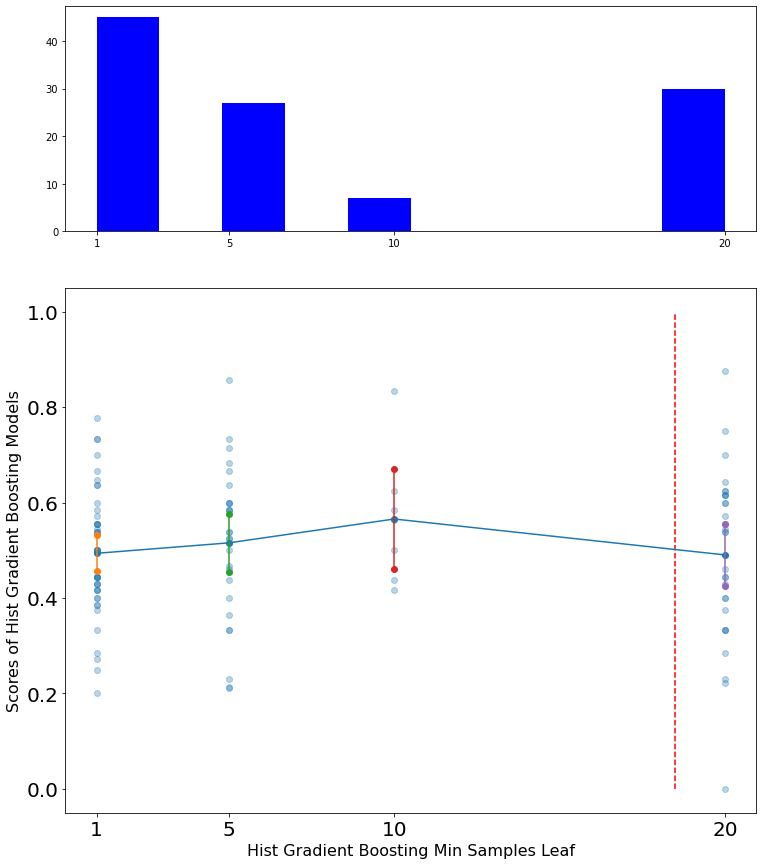

In [148]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

ax_0_0.scatter(leaf, score_hist, alpha=0.3)
ax_0_0.vlines(x=18.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Min Samples Leaf", fontsize=16)
ax_0_0.set_ylabel("Scores of Hist Gradient Boosting Models", fontsize=16)

ax1_histx.hist(leaf, color='blue')

score_hist = np.array(score_hist)
leaf = np.array(leaf)

ax_0_0.plot(np.array([1, 5, 10, 20]), 
        np.array([score_hist[leaf==1].mean(), score_hist[leaf==5].mean(), score_hist[leaf==10].mean(), score_hist[leaf==20].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([1, 1]), 
        np.array([score_hist[leaf==1].mean()-1.96*pd.Series(score_hist[leaf==1]).sem(), score_hist[leaf==1].mean()+1.96*pd.Series(score_hist[leaf==1]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_hist[leaf==5].mean()-1.96*pd.Series(score_hist[leaf==5]).sem(), score_hist[leaf==5].mean()+1.96*pd.Series(score_hist[leaf==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_hist[leaf==10].mean()-1.96*pd.Series(score_hist[leaf==10]).sem(), score_hist[leaf==10].mean()+1.96*pd.Series(score_hist[leaf==10]).sem()]), marker='o')
ax_0_0.plot(np.array([20, 20]), 
        np.array([score_hist[leaf==20].mean()-1.96*pd.Series(score_hist[leaf==20]).sem(), score_hist[leaf==20].mean()+1.96*pd.Series(score_hist[leaf==20]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([1, 5, 10, 20]))

fig.show()

In [159]:
Counter(criterion)

Counter({'entropy': 79, 'gini': 30})

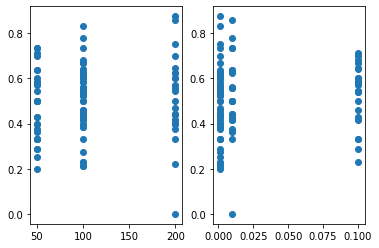

In [141]:
plt.subplot(1,2,1)
plt.scatter(max_iter, score_hist)
plt.subplot(1,2,2)
plt.scatter(lr, score_hist)
plt.show()

In [224]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsOneClassifier

param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
param_grid2 = {
    "criterion": ['entropy', 'gini'], 
    "min_samples_split": [2,5,10]
}
param_grid3 = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_iter": [50, 100, 200],
    "max_depth": [3, 5, 10], 
    "min_samples_leaf": [1, 5, 10, 20]
}
score_iterative = []
faces_test_data = np.stack(list(faces_test.values())).reshape(-1,4096)
svm_faces = SVC(kernel="rbf", class_weight="balanced", probability=True, C=3887.783057567878, gamma=0.001)
rf = RandomForestClassifier(criterion='entropy', min_samples_split=2)
hist = HistGradientBoostingClassifier(learning_rate=0.001, max_iter=200, max_depth=5, min_samples_leaf=1)
knn = KNeighborsClassifier(n_neighbors=4)

voting_models = []

voting_classes = file_train_classes
for i in tqdm(range(len(face_classes_array)//3)):
    face_classes = np.concatenate(face_classes_array[i*3:i*3+3])
    np.random.seed(100)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    face_classes_train = face_classes[idx[:int(0.7*len(face_classes))]]
    faces_data = np.vstack(faces_chunk_array[i*3:i*3+3])
    faces_data_train = faces_data[idx[:int(0.7*len(face_classes))]]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(faces_data_train)
    pca = PCA(n_components=min(X_train.shape[0]-1, X_train.shape[1]-1))
    X_pca_train = pca.fit_transform(X_train)
    
    estim = VotingClassifier(estimators=[
        ('svm', svm_faces), ('rf', rf), ('hist', hist), ('knn', knn)
    ], voting='soft')
    voting_classifier_iterative = estim
    
    voting_classifier_iterative.fit(X_pca_train, face_classes_train)
    
    face_classes_test = face_classes[idx[int(0.7*len(face_classes)):]]
    faces_data_test = faces_data[idx[int(0.7*len(face_classes)):]]
    
    X_test = scaler.transform(faces_data_test)
    X_pca_test = pca.transform(X_test)
    
    voting_models.append(voting_classifier_iterative)
    
    score_iterative.append(accuracy_score(face_classes_test, voting_classifier_iterative.predict(X_pca_test)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [04:14<00:00,  2.34s/it]


In [486]:
f_faces_test = np.vstack(list(faces_test.values()))
X_test = scaler.transform(f_faces_test.reshape(-1,4096))
X_pca_test = pca.transform(X_test)
X_pca_test_inverse = pca.inverse_transform(X_pca_test)

In [488]:
accuracy_score(file_new_classes, mlp.predict(scaler2.transform(X_pca_test)))

0.0478515625

In [393]:
svm_ensemble.predict(X_pca_test)

array(['JhonLenon', 'CelesteHolm', 'EdwigeFenech', ..., 'HumphreyBogard',
       'JamesArness', 'OrnellaMuti'], dtype='<U20')

In [451]:
X_pca_train.shape

(4112, 150)

In [25]:
face_classes_train

NameError: name 'face_classes_train' is not defined

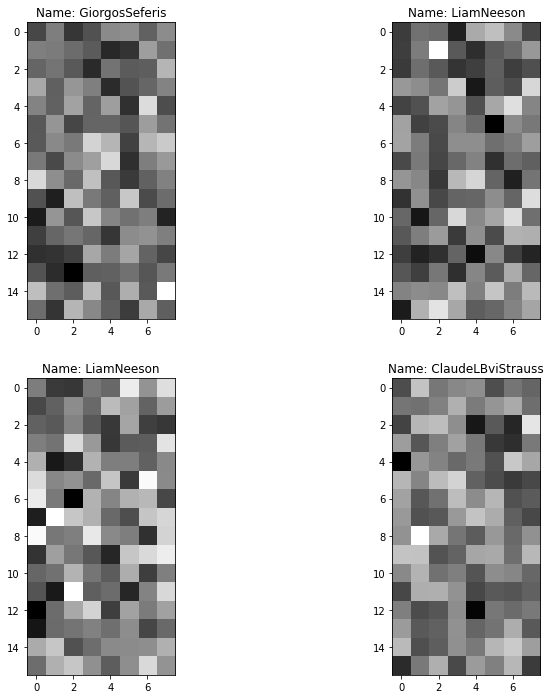

In [370]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
for i in range(4):
    ax[i//2,i%2].set_title("Name: " + face_classes_train[i])
    ax[i//2,i%2].imshow(faces_data_train[i].reshape(16,8), cmap='gray')

In [42]:
data

face_id        identity  cluster_label
0           0     OrnellaMuti              0
1           1  Thanasisveggos              1
2           4    LaurenBacall              1
3           7       JhonLenon              1
4           8      ScottGlenn              1
...       ...             ...            ...
9276     9269  MurrayHamilton           4816
9277     9270    JulieAndrews           4817
9278     9273   PierceBrosnan           4818
9279     9275         MegRyan           4819
9280     9276     GeneHackman           4820

[9281 rows x 3 columns]

In [30]:
from copy import copy
from collections import Counter

copy_classes = copy(labels_train)
faces_chunk_train = []
faces_chunk_array_train = []
face_classes_train = []
face_classes_array_train = []
for name, counter_class in tqdm(dict(Counter(copy_classes)).items()):
    df = data[
        data['identity'] == name
    ]
    for idx, row in df.iterrows():
        faces_chunk_train.append(embeddings_train[row['face_id']])
        face_classes_train.append(name)
    face_classes_array_train.append(face_classes_train)
    faces_chunk_array_train.append(faces_chunk_train)
    faces_chunk_train = []
    face_classes_train = []

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:02<00:00, 124.87it/s]


In [343]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

score_embedding = []
svm_embedding_array = []

svm_embedding_array = []
rf_embedding_array = []
hist_embedding_array = []
knn_embeding_array = []
param_grid = {
    "C": loguniform(0.1, 100),
    "gamma": loguniform(1e-4, 1e-1),
}
param_grid2 = {
    "criterion": ['entropy', 'gini'], 
    "min_samples_split": [2,5,10]
}
param_grid3 = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_iter": [50, 100, 200],
    "max_depth": [3, 5, 10], 
    "min_samples_leaf": [1, 5, 10, 20]
}

voting_classifier_array = []
face_classes_count = 0
for i in tqdm(range(len(face_classes_array_train)//3)):
    face_classes = np.concatenate(face_classes_array_train[i*3:i*3+3])
    np.random.seed(100)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    face_classes_train = face_classes[idx[:int(0.7*len(face_classes))]]
    faces_data = np.vstack(faces_chunk_array_train[i*3:i*3+3])
    faces_data_train = faces_data[idx[:int(0.7*len(face_classes))]]
    
    face_classes_test = face_classes[idx[int(0.7*len(face_classes)):]]
    faces_data_test = faces_data[idx[int(0.7*len(face_classes)):]]
    
    svm_embeding = RandomizedSearchCV(
        SVC(kernel="linear", probability=True), param_grid, n_iter=10, cv=2
    )
    rf_emb = RandomizedSearchCV(RandomForestClassifier(), param_grid2, n_iter=10, cv=2)
    hist_emb = RandomizedSearchCV(HistGradientBoostingClassifier(), param_grid3, n_iter=10, cv=2)
    knn_emb = KNeighborsClassifier(n_neighbors=4)
    
    voting_classifier = VotingClassifier(estimators=[
        ('svm', svm_embeding), ('rf', rf_emb), ('hist', hist_emb), ('knn', knn_emb)
    ], voting='soft')
    
    voting_classifier.fit(faces_data_train, face_classes_train)
    
    svm_embedding_array.append(voting_classifier.named_estimators_.svm)
    rf_embedding_array.append(voting_classifier.named_estimators_.rf)
    hist_embedding_array.append(voting_classifier.named_estimators_.hist)
    knn_embeding_array.append(knn_emb)
    
    score_embedding.append(accuracy_score(face_classes_test, voting_classifier.predict(faces_data_test)) * len(face_classes))
    voting_classifier_array.append(voting_classifier)
    face_classes_count += len(face_classes)

  0%|                                                                                                                    | 0/110 [00:00<?, ?it/s]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  1%|▉                                                                                                           | 1/110 [00:21<39:42, 21.86s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  2%|█▉                                                                                                          | 2/110 [00:47<43:13, 24.01s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 19%|████████████████████▍                                                                                      | 21/110 [09:38<45:18, 30.55s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 20%|█████████████████████▍                                                                                     | 22/110 [10:09<44:54, 30.62s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 21%|██████████████████████▎                                                                                    | 23/110 [10:30<40:13, 27.75s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 38%|████████████████████████████████████████▊                                                                  | 42/110 [20:43<28:29, 25.13s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 39%|█████████████████████████████████████████▊                                                                 | 43/110 [21:14<29:55, 26.80s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 40%|██████████████████████████████████████████▊                                                                | 44/110 [21:34<27:07, 24.66s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 57%|█████████████████████████████████████████████████████████████▎                                             | 63/110 [31:02<23:09, 29.57s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 58%|██████████████████████████████████████████████████████████████▎                                            | 64/110 [31:41<24:49, 32.38s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 59%|███████████████████████████████████████████████████████████████▏                                           | 65/110 [32:13<24:10, 32.23s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 84/110 [40:47<12:49, 29.59s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 85/110 [41:19<12:37, 30.30s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 86/110 [41:47<11:52, 29.70s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 105/110 [49:33<01:48, 21.72s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 106/110 [49:48<01:18, 19.67s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████   | 107/110 [50:07<00:58, 19.51s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn

In [344]:
(np.array(score_embedding) / face_classes_count).sum(), pd.DataFrame((np.array(score_embedding) / face_classes_count)).sem() * np.sqrt(len(score_embedding))

(0.8849477000300143,
 0    0.001654
 dtype: float64)

In [354]:
(np.array(score_embedding) / face_classes_count).sum(), pd.DataFrame((np.array(score_embedding) / face_classes_count)).sem() * np.sqrt(len(score_embedding))

(0.8849477001952706,
 0    0.001654
 dtype: float64)

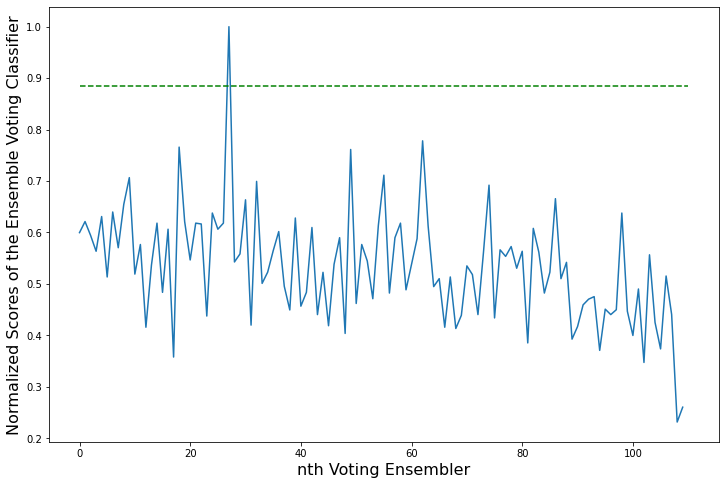

In [368]:
fig = plt.figure(figsize=(12,8))
plt.plot(list(range(len(score_embedding))), score_embedding / score_embedding.max())
plt.hlines(y=0.885, xmax=110, xmin=0, linestyles='dashed', color='green')
plt.ylabel("Normalized Scores of the Ensemble Voting Classifier", fontsize=16)
plt.xlabel("nth Voting Ensembler", fontsize=16)
plt.show()

In [345]:
pickle.dump(embeddings_facenet, open(SAVEDIR + "/embeddings_facenet.pkl", "wb"))
pickle.dump(images_dict, open(SAVEDIR + "/images_dict.pkl", "wb"))

In [367]:
pickle.dump(voting_classifier_array, open(SAVEDIR + "/voting_classifier_array.pkl", "wb"))
pickle.dump(score_embedding, open(SAVEDIR + "/score_embedding.pkl", "wb"))
pickle.dump(svm_embedding_array, open(SAVEDIR + "/svm_embedding_array.pkl", "wb"))
pickle.dump(rf_embedding_array, open(SAVEDIR + "/rf_embedding_array.pkl", "wb"))
pickle.dump(hist_embedding_array, open(SAVEDIR + "/hist_embedding_array.pkl", "wb"))
pickle.dump(knn_embeding_array, open(SAVEDIR + "/knn_embedding_array.pkl", "wb"))

In [46]:
svm_emb_array = [svm_cv.best_estimator_ for svm_cv in svm_embedding_array]
rf_emb_array = [rf_cv.best_estimator_ for rf_cv in rf_embedding_array]
h_emb_array = [hist.best_estimator_ for hist in hist_embedding_array]

In [347]:
c_array = [svm_model.C for svm_model in svm_emb_array]
split = [rf_model.min_samples_split for rf_model in rf_emb_array]
depth = [hist_model.max_depth for hist_model in h_emb_array]
leaf = [hist_model.min_samples_leaf for hist_model in h_emb_array]
max_iter = [hist_model.max_iter for hist_model in h_emb_array]
lr = [hist_model.learning_rate for hist_model in h_emb_array]
criterion = [rf_model.criterion for rf_model in rf_emb_array]

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


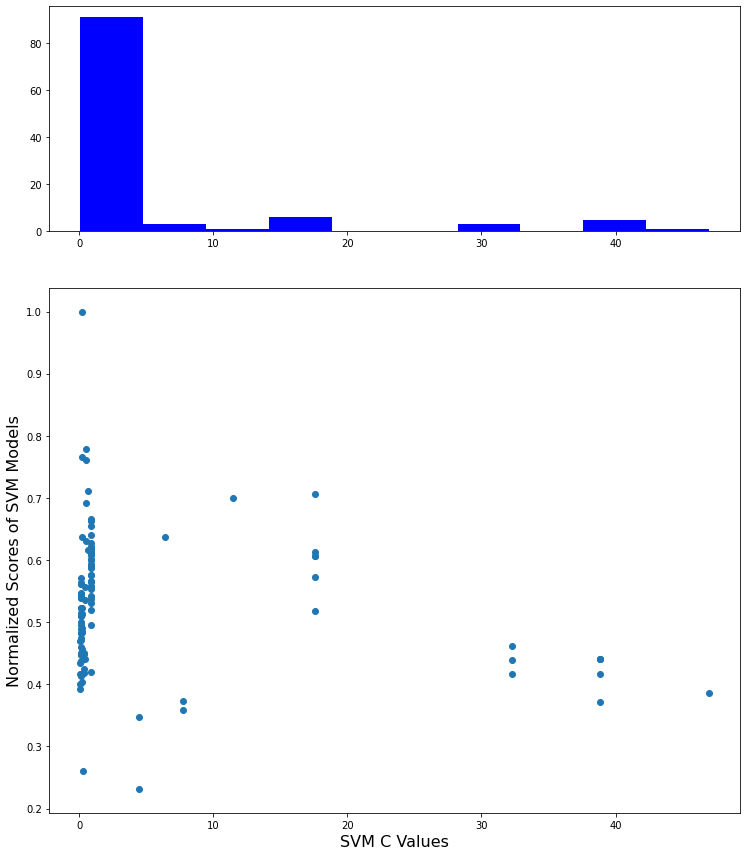

In [348]:
# start with a square Figure
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding = np.array(score_embedding)
ax_0_0.scatter(c_array, score_embedding / score_embedding.max())
# ax_0_0.vlines(x=10000, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("SVM C Values", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of SVM Models", fontsize=16)

ax1_histx.hist(c_array, color='blue')
fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


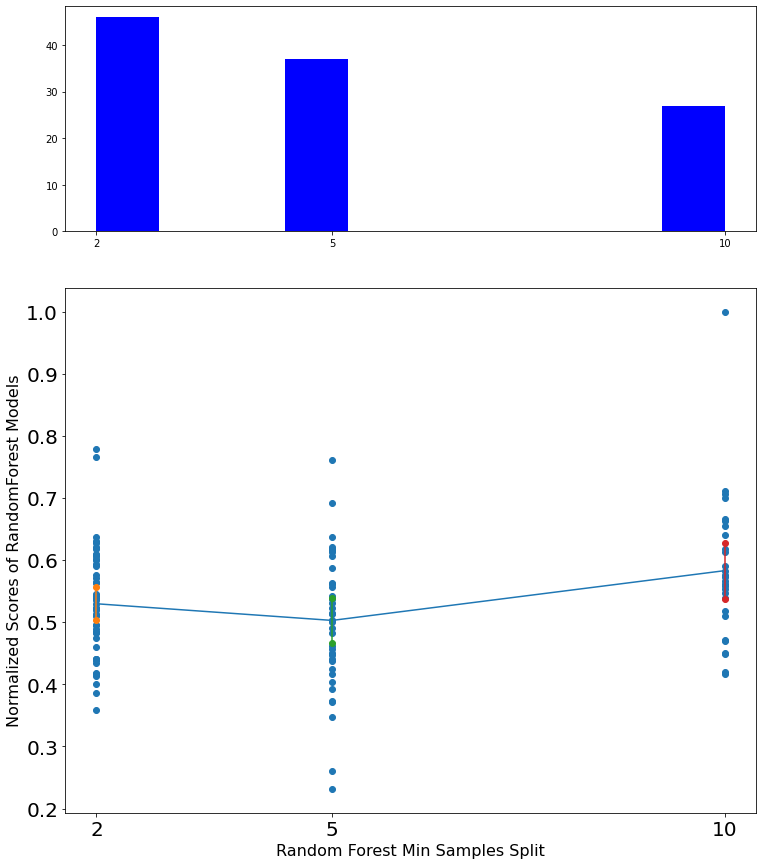

In [349]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

score_embedding = np.array(score_embedding) / score_embedding.max()

ax_0_0.scatter(split, score_embedding)
# ax_0_0.vlines(x=2.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Random Forest Min Samples Split", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of RandomForest Models", fontsize=16)

ax1_histx.hist(split, color='blue')

split = np.array(split)

ax_0_0.plot(np.array([2, 5, 10]), 
        np.array([score_embedding[split==2].mean(), score_embedding[split==5].mean(), score_embedding[split==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([2, 2]), 
        np.array([score_embedding[split==2].mean()-1.96*pd.Series(score_embedding[split==2]).sem(), score_embedding[split==2].mean()+1.96*pd.Series(score_embedding[split==2]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding[split==5].mean()-1.96*pd.Series(score_embedding[split==5]).sem(), score_embedding[split==5].mean()+1.96*pd.Series(score_embedding[split==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding[split==10].mean()-1.96*pd.Series(score_embedding[split==10]).sem(), score_embedding[split==10].mean()+1.96*pd.Series(score_embedding[split==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([2, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


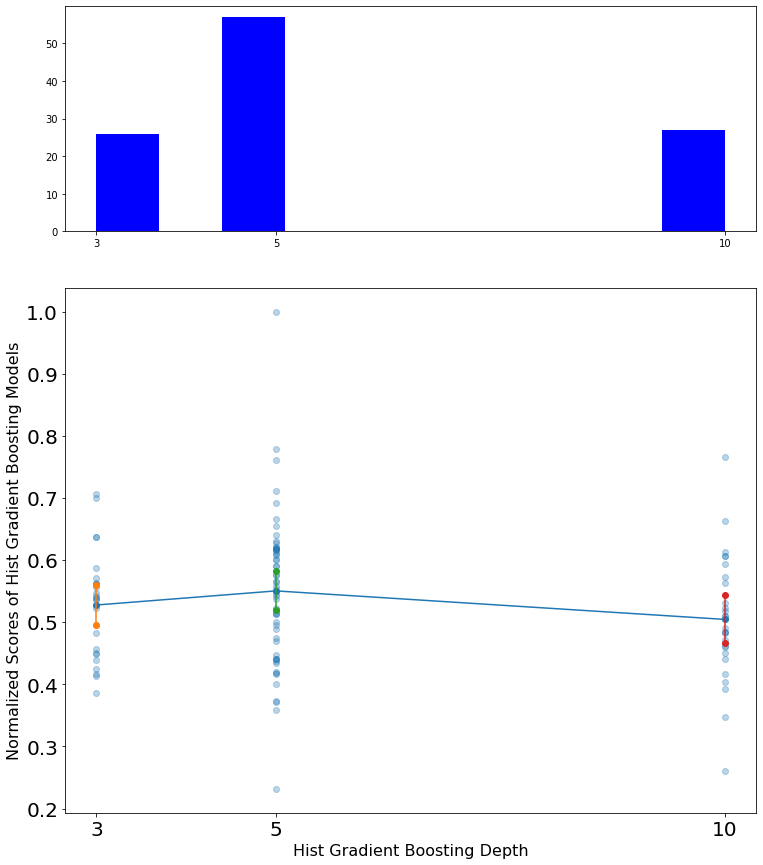

In [350]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding = np.array(score_embedding)
ax_0_0.scatter(depth, score_embedding, alpha=0.3)
# ax_0_0.vlines(x=3.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Depth", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of Hist Gradient Boosting Models", fontsize=16)

ax1_histx.hist(depth, color='blue')

depth = np.array(depth)

ax_0_0.plot(np.array([3, 5, 10]), 
        np.array([score_embedding[depth==3].mean(), score_embedding[depth==5].mean(), score_embedding[depth==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([3, 3]), 
        np.array([score_embedding[depth==3].mean()-1.96*pd.Series(score_embedding[depth==3]).sem(), score_embedding[depth==3].mean()+1.96*pd.Series(score_embedding[depth==3]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding[depth==5].mean()-1.96*pd.Series(score_embedding[depth==5]).sem(), score_embedding[depth==5].mean()+1.96*pd.Series(score_embedding[depth==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding[depth==10].mean()-1.96*pd.Series(score_embedding[depth==10]).sem(), score_embedding[depth==10].mean()+1.96*pd.Series(score_embedding[depth==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([3, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


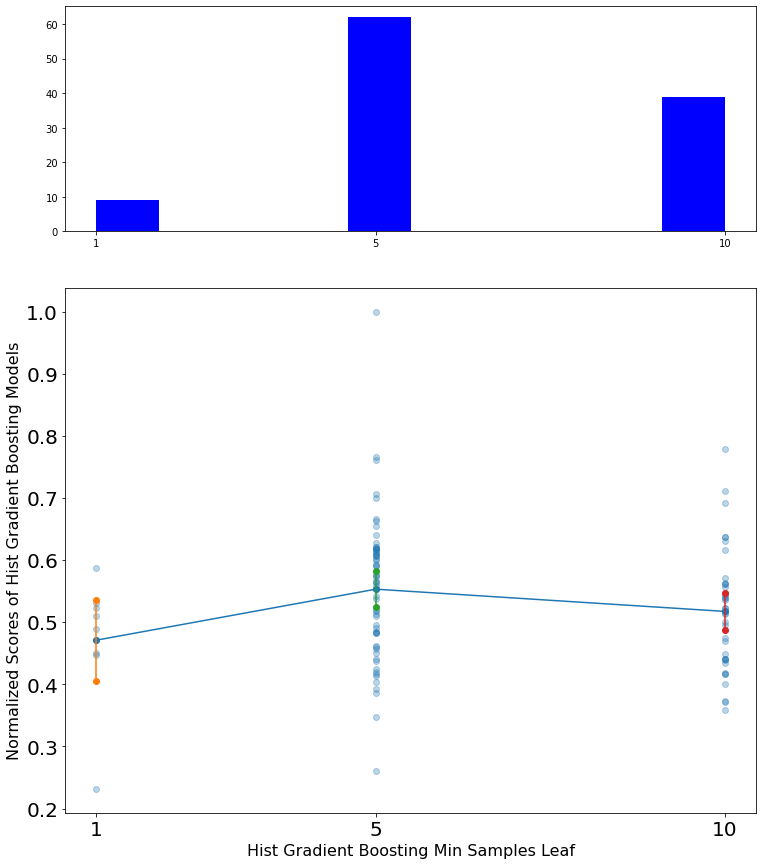

In [351]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding = np.array(score_embedding)
ax_0_0.scatter(leaf, score_embedding, alpha=0.3)
# ax_0_0.vlines(x=18.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Min Samples Leaf", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of Hist Gradient Boosting Models", fontsize=16)

ax1_histx.hist(leaf, color='blue')

leaf = np.array(leaf)

ax_0_0.plot(np.array([1, 5, 10]), 
        np.array([score_embedding[leaf==1].mean(), score_embedding[leaf==5].mean(), score_embedding[leaf==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([1, 1]), 
        np.array([score_embedding[leaf==1].mean()-1.96*pd.Series(score_embedding[leaf==1]).sem(), score_embedding[leaf==1].mean()+1.96*pd.Series(score_embedding[leaf==1]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding[leaf==5].mean()-1.96*pd.Series(score_embedding[leaf==5]).sem(), score_embedding[leaf==5].mean()+1.96*pd.Series(score_embedding[leaf==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding[leaf==10].mean()-1.96*pd.Series(score_embedding[leaf==10]).sem(), score_embedding[leaf==10].mean()+1.96*pd.Series(score_embedding[leaf==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([1, 5, 10]))

fig.show()

## Testing / Calculating images accuracy individually

In [53]:
data_test

face_id        identity
0           0       AbeVigoda
1           1       AbeVigoda
2           2       AbeVigoda
3           3       AbeVigoda
4           4    AdolfHitlerr
...       ...             ...
1027     1027        campbell
1028     1028        campbell
1029     1029  michaeljackson
1030     1030    motherTereza
1031     1031    motherTereza

[1032 rows x 2 columns]

In [55]:
from copy import copy
from collections import Counter

copy_classes = copy(labels_test)
faces_chunk_train = []
faces_chunk_array_train = []
face_classes_train = []
face_classes_array_train = []
for name, counter_class in tqdm(dict(Counter(copy_classes)).items()):
    df = data_test[
        data_test['identity'] == name
    ]
    for idx, row in df.iterrows():
        faces_chunk_train.append(embeddings_test[row['face_id']])
        face_classes_train.append(name)
    face_classes_array_train.append(face_classes_train)
    faces_chunk_array_train.append(faces_chunk_train)
    faces_chunk_train = []
    face_classes_train = []

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 549.58it/s]


In [48]:
from copy import copy
from sklearn.metrics import accuracy_score

voting_classifier_array_copy = copy(voting_classifier_array)

accuracy = {}
for i in tqdm(range(len(face_classes_array_train))):
    face_classes = np.concatenate(face_classes_array_train[i:i+1])
    np.random.seed(1000)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    faces_data = np.vstack(faces_chunk_array_train[i:i+1])
    
    for j in range(len(voting_classifier_array_copy)):
        voting_classifier = voting_classifier_array_copy[j]
        if face_classes[0] in voting_classifier.classes_:
            if face_classes[0] not in accuracy:
                accuracy[face_classes[0]] = []
            accuracy[face_classes[0]].append((accuracy_score(face_classes, 
                                                           voting_classifier.predict(faces_data)), 
                                             len(voting_classifier.classes_)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:05<00:00, 54.38it/s]


In [49]:
accuracy

{'AbeVigoda': [(0.75, 3)],
 'AdolfHitlerr': [(1.0, 3)],
 'AlanRickman': [(0.6666666666666666, 3)],
 'AlecGuinness': [(1.0, 3)],
 'AlejandroRey': [(1.0, 3)],
 'AlexanderGrahamBell': [(1.0, 3)],
 'AliMacGraw': [(1.0, 3)],
 'AndreMarieAmpКre': [(1.0, 3)],
 'AndyGriffith': [(1.0, 3)],
 'AngelaLansbury': [(1.0, 3)],
 'AngieDickinson': [(1.0, 3)],
 'AnnJillian': [(1.0, 3)],
 'AnnMargret': [(0.5, 3)],
 'AnnMiller': [(1.0, 3)],
 'AnnaMassey': [(1.0, 3)],
 'AnneBancroft': [(0.5, 3)],
 'AnnetteBening': [(1.0, 3)],
 'AnthonyAndrews': [(1.0, 3)],
 'AnthonyHopkins': [(1.0, 3)],
 'AnthonyQuayle': [(0.8, 3)],
 'Arletty': [(1.0, 3)],
 'AvaGardner': [(1.0, 3)],
 'BarbaraBain': [(1.0, 3)],
 'BarbaraBouchet': [(1.0, 3)],
 'BarbraStreisand': [(1.0, 3)],
 'BeaArthur': [(1.0, 3)],
 'BenGazzara': [(0.7142857142857143, 3)],
 'BernadetteLafont': [(1.0, 3)],
 'BetteDavis': [(1.0, 3)],
 'BetteMidler': [(1.0, 3)],
 'BettyGarrett': [(1.0, 3)],
 'BobDylan': [(1.0, 3)],
 'BorisKarloff': [(0.625, 3)],
 'BrianDennehy'

In [52]:
for key, acc in list(accuracy.items()):
    print("""Predicted identity: {identity}, 
    Accuracy Score: {accuracy}, 
    Out of Classes: {no_of_classes}
    -------------------------------""".format(
        identity=key, 
        accuracy=acc[0][0], 
        no_of_classes=acc[0][1]
    ))

Predicted identity: AbeVigoda, 
    Accuracy Score: 0.75, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AdolfHitlerr, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AlanRickman, 
    Accuracy Score: 0.6666666666666666, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AlecGuinness, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AlejandroRey, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AlexanderGrahamBell, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AliMacGraw, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AndreMarieAmpКre, 
    Accuracy Score: 1.0, 
    Out of Classes: 3
    -------------------------------
Predicted identity: AndyGri

In [7]:
merged_sample.shape

(10313, 5)

In [39]:
data.shape

(9281, 3)

In [57]:
labels_train[-10:]

['NewmanPaul',
 'ErnestBorgnine',
 'PierceBrosnan',
 'WillSmith ',
 'MegRyan',
 'GeneHackman',
 'GladysCooper',
 'AngelaLansbury',
 'TildaSwinton',
 'NelsonMandela']

In [58]:
new_data = data.sort_values(by=['face_id'])
new_data

face_id        identity  cluster_label
0           0     OrnellaMuti              0
1           1  Thanasisveggos              1
3896        2   JohnMalkovich              2
3897        3      JohnnyCash              3
2           4    LaurenBacall              1
...       ...             ...            ...
9280     9276     GeneHackman           4820
3893     9277    GladysCooper              1
3894     9278  AngelaLansbury              1
8258     9279    TildaSwinton           3808
3895     9280   NelsonMandela              1

[9281 rows x 3 columns]

In [59]:
new_data['filename'] = files_train
new_data

face_id        identity  cluster_label                       filename
0           0     OrnellaMuti              0     10765_OrnellaMuti_29_f.jpg
1           1  Thanasisveggos              1   9423_Thanasisveggos_33_m.jpg
3896        2   JohnMalkovich              2    5393_JohnMalkovich_57_m.jpg
3897        3      JohnnyCash              3       6486_JohnnyCash_41_m.jpg
2           4    LaurenBacall              1    11558_LaurenBacall_42_f.jpg
...       ...             ...            ...                            ...
9280     9276     GeneHackman           4820      3228_GeneHackman_37_m.jpg
3893     9277    GladysCooper              1     7119_GladysCooper_66_m.jpg
3894     9278  AngelaLansbury              1  11951_AngelaLansbury_25_f.jpg
8258     9279    TildaSwinton           3808    11774_TildaSwinton_45_f.jpg
3895     9280   NelsonMandela              1   16018_NelsonMandela_40_m.jpg

[9281 rows x 4 columns]

In [80]:
new_data.sort_values(by=['identity', 'age'])

face_id      identity  cluster_label                   filename  age
1248     3120     AbeVigoda              1    2359_AbeVigoda_20_m.jpg   20
1379     3448     AbeVigoda              1    2325_AbeVigoda_49_m.jpg   49
4207      362     AbeVigoda            220    2326_AbeVigoda_51_m.jpg   51
6127     3152     AbeVigoda           1785    2328_AbeVigoda_53_m.jpg   53
2893     6892     AbeVigoda              1    2329_AbeVigoda_54_m.jpg   54
...       ...           ...            ...                        ...  ...
2590     6222  motherTereza              1  484_motherTereza_76_f.jpg   76
2481     5973  motherTereza              1  483_motherTereza_78_f.jpg   78
3216     7634  motherTereza              1  505_motherTereza_80_f.jpg   80
2524     6079  motherTereza              1  495_motherTereza_82_f.jpg   82
1145     2843  motherTereza              1  494_motherTereza_85_f.jpg   85

[9281 rows x 5 columns]

In [67]:
new_data['age'] = ages_train
new_data

face_id        identity  cluster_label                       filename  \
0           0     OrnellaMuti              0     10765_OrnellaMuti_29_f.jpg   
1           1  Thanasisveggos              1   9423_Thanasisveggos_33_m.jpg   
3896        2   JohnMalkovich              2    5393_JohnMalkovich_57_m.jpg   
3897        3      JohnnyCash              3       6486_JohnnyCash_41_m.jpg   
2           4    LaurenBacall              1    11558_LaurenBacall_42_f.jpg   
...       ...             ...            ...                            ...   
9280     9276     GeneHackman           4820      3228_GeneHackman_37_m.jpg   
3893     9277    GladysCooper              1     7119_GladysCooper_66_m.jpg   
3894     9278  AngelaLansbury              1  11951_AngelaLansbury_25_f.jpg   
8258     9279    TildaSwinton           3808    11774_TildaSwinton_45_f.jpg   
3895     9280   NelsonMandela              1   16018_NelsonMandela_40_m.jpg   

      age  
0      29  
1      33  
3896   57  
3897   41  
2      42  
...   ...  
9280   37  
3893   66  
3894   25  
8258   45  
3895   40  

[9281 rows x 5 columns]

In [119]:
from copy import copy
from collections import Counter

copy_classes = copy(labels_train)
faces_chunk_train_age = []
faces_chunk_array_train_age = []
face_classes_train_age = []
face_classes_array_train_age = []
faces_chunk_test_age = []
faces_chunk_array_test_age = []
face_classes_test_age = []
face_classes_array_test_age = []
for name, counter_class in tqdm(dict(Counter(copy_classes)).items()):
    df1 = new_data[
        (new_data['identity'] == name) & (new_data['age'] >= 46)
    ]
    df2 = new_data[
        (new_data['identity'] == name) & (new_data['age'] <= 48)
    ]
    if len(df1) == 0 or len(df2) == 0:
        continue
    for idx, row in df1.iterrows():
        faces_chunk_test_age.append(embeddings_train[row['face_id']])
        face_classes_test_age.append(name)
    face_classes_array_test_age.append(face_classes_test_age)
    faces_chunk_array_test_age.append(faces_chunk_test_age)
    faces_chunk_test_age = []
    face_classes_test_age = []
    
    for idx, row in df2.iterrows():
        faces_chunk_train_age.append(embeddings_train[row['face_id']])
        face_classes_train_age.append(name)
    face_classes_array_train_age.append(face_classes_train_age)
    faces_chunk_array_train_age.append(faces_chunk_train_age)
    faces_chunk_train_age = []
    face_classes_train_age = []

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:02<00:00, 111.40it/s]


In [129]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

score_embedding_age = []
svm_embedding_array_age = []

svm_embedding_array_age = []
rf_embedding_array_age = []
hist_embedding_array_age = []
knn_embeding_array_age = []
param_grid = {
    "C": loguniform(0.1, 100),
    "gamma": loguniform(1e-4, 1e-1),
}
param_grid2 = {
    "criterion": ['entropy', 'gini'], 
    "min_samples_split": [2,5,10]
}
param_grid3 = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_iter": [50, 100, 200],
    "max_depth": [3, 5, 10], 
    "min_samples_leaf": [1, 5, 10, 20]
}

voting_classifier_array_age = []
face_classes_count = 0
for i in tqdm(range(len(face_classes_array_train_age)//3)):
    face_classes = np.concatenate(face_classes_array_train_age[i*3:i*3+3])
    np.random.seed(100)
    idx = np.arange(len(face_classes))
    np.random.shuffle(idx)
    face_classes_train = face_classes
    faces_data = np.vstack(faces_chunk_array_train_age[i*3:i*3+3])
    faces_data_train = faces_data
    
    face_classes_test = np.concatenate(face_classes_array_test_age[i*3:i*3+3])
    faces_data_test = np.vstack(faces_chunk_array_test_age[i*3:i*3+3])
    
    svm_embeding = RandomizedSearchCV(
        SVC(kernel="linear", probability=True), param_grid, n_iter=10, cv=2
    )
    rf_emb = RandomizedSearchCV(RandomForestClassifier(), param_grid2, n_iter=10, cv=2)
    hist_emb = RandomizedSearchCV(HistGradientBoostingClassifier(), param_grid3, n_iter=10, cv=2)
    knn_emb = KNeighborsClassifier(n_neighbors=4)
    
    voting_classifier_age = VotingClassifier(estimators=[
        ('svm', svm_embeding), ('rf', rf_emb), ('hist', hist_emb), ('knn', knn_emb)
    ], voting='soft')
    
    voting_classifier_age.fit(faces_data_train, face_classes_train)
    
    svm_embedding_array_age.append(voting_classifier_age.named_estimators_.svm)
    rf_embedding_array_age.append(voting_classifier_age.named_estimators_.rf)
    hist_embedding_array_age.append(voting_classifier_age.named_estimators_.hist)
    knn_embeding_array_age.append(knn_emb)
    
    score_embedding_age.append(accuracy_score(face_classes_test, voting_classifier_age.predict(faces_data_test)) * (len(face_classes)+len(face_classes_test)))
    voting_classifier_array_age.append(voting_classifier_age)
    face_classes_count += (len(face_classes) + len(face_classes_test))

  0%|                                                                                                                                                          | 0/106 [00:00<?, ?it/s]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  1%|█▍                                                                                                                                                | 1/106 [00:12<21:59, 12.56s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
  2%|██▊                                                                                                                              

 17%|████████████████████████▌                                                                                                                        | 18/106 [04:06<21:09, 14.42s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 18%|█████████████████████████▉                                                                                                                       | 19/106 [04:20<21:05, 14.55s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 19%|███████████████████████████▎                                                                                                     

 35%|██████████████████████████████████████████████████▌                                                                                              | 37/106 [09:34<19:13, 16.72s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 36%|███████████████████████████████████████████████████▉                                                                                             | 38/106 [09:50<19:00, 16.78s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 37%|█████████████████████████████████████████████████████▎                                                                           

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 55/106 [14:12<15:22, 18.08s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 56/106 [14:32<15:33, 18.66s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 54%|█████████████████████████████████████████████████████████████████████████████▉                                                   

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 74/106 [19:42<08:20, 15.63s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 75/106 [20:05<09:16, 17.95s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                         

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 93/106 [24:46<03:21, 15.49s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 94/106 [25:04<03:13, 16.12s/it]C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [132]:
(np.array(score_embedding_age) / face_classes_count).sum(), pd.DataFrame((np.array(score_embedding_age) / face_classes_count)).sem() * np.sqrt(len(score_embedding_age))

(0.8460848725715877,
 0    0.001782
 dtype: float64)

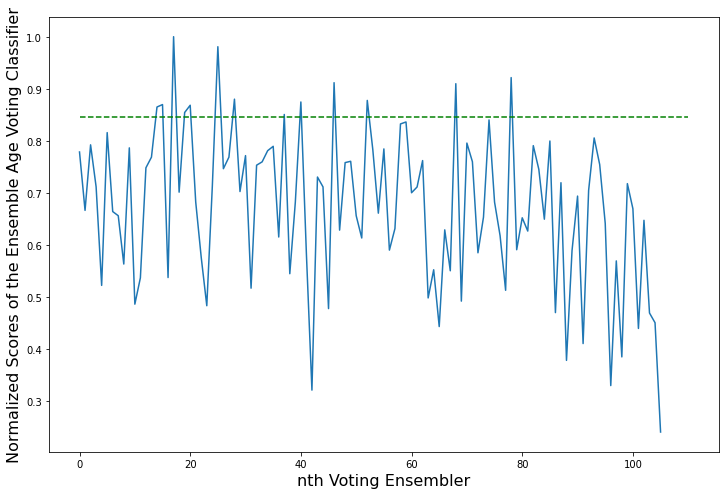

In [136]:
score_embedding_age = np.array(score_embedding_age)
fig = plt.figure(figsize=(12,8))
plt.plot(list(range(len(score_embedding_age))), score_embedding_age / score_embedding_age.max())
plt.hlines(y=0.846, xmax=110, xmin=0, linestyles='dashed', color='green')
plt.ylabel("Normalized Scores of the Ensemble Age Voting Classifier", fontsize=16)
plt.xlabel("nth Voting Ensembler", fontsize=16)
plt.show()

In [137]:
svm_emb_array = [svm_cv.best_estimator_ for svm_cv in svm_embedding_array_age]
rf_emb_array = [rf_cv.best_estimator_ for rf_cv in rf_embedding_array_age]
h_emb_array = [hist.best_estimator_ for hist in hist_embedding_array_age]

In [138]:
c_array = [svm_model.C for svm_model in svm_emb_array]
split = [rf_model.min_samples_split for rf_model in rf_emb_array]
depth = [hist_model.max_depth for hist_model in h_emb_array]
leaf = [hist_model.min_samples_leaf for hist_model in h_emb_array]
max_iter = [hist_model.max_iter for hist_model in h_emb_array]
lr = [hist_model.learning_rate for hist_model in h_emb_array]
criterion = [rf_model.criterion for rf_model in rf_emb_array]

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


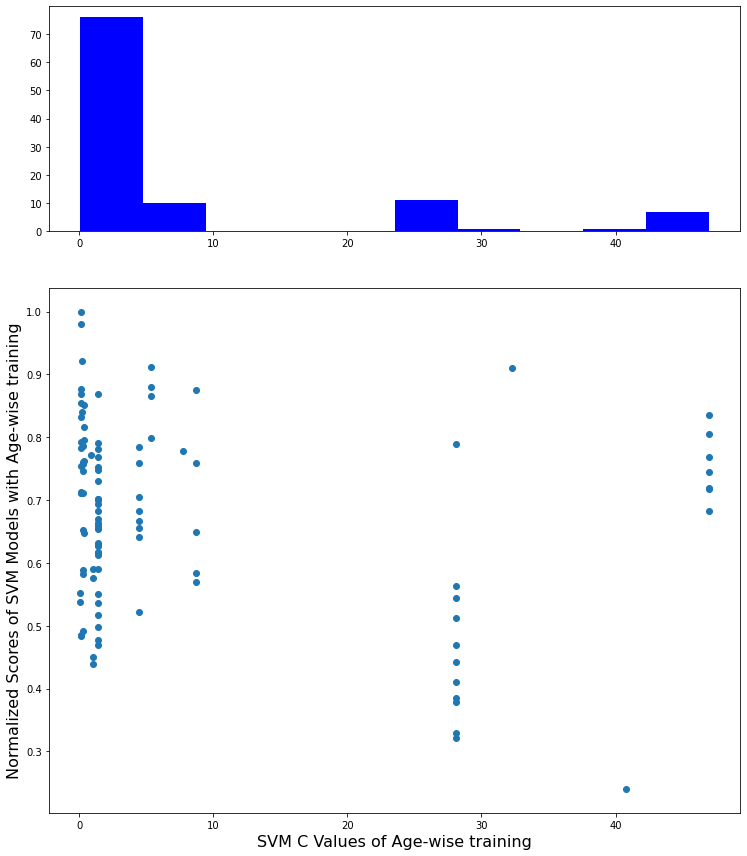

In [139]:
# start with a square Figure
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding_age = np.array(score_embedding_age)
ax_0_0.scatter(c_array, score_embedding_age / score_embedding_age.max())
# ax_0_0.vlines(x=10000, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("SVM C Values of Age-wise training", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of SVM Models with Age-wise training", fontsize=16)

ax1_histx.hist(c_array, color='blue')
fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


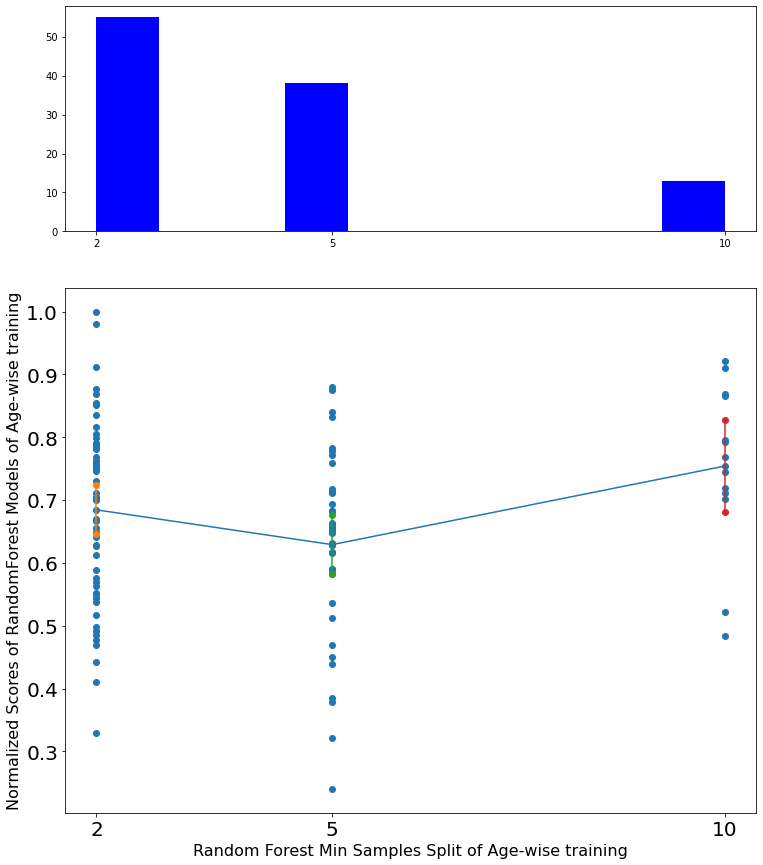

In [140]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)

score_embedding_age_1 = np.array(score_embedding_age) / score_embedding_age.max()

ax_0_0.scatter(split, score_embedding_age_1)
# ax_0_0.vlines(x=2.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Random Forest Min Samples Split of Age-wise training", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of RandomForest Models of Age-wise training", fontsize=16)

ax1_histx.hist(split, color='blue')

split = np.array(split)

ax_0_0.plot(np.array([2, 5, 10]), 
        np.array([score_embedding_age_1[split==2].mean(), score_embedding_age_1[split==5].mean(), score_embedding_age_1[split==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([2, 2]), 
        np.array([score_embedding_age_1[split==2].mean()-1.96*pd.Series(score_embedding_age_1[split==2]).sem(), score_embedding_age_1[split==2].mean()+1.96*pd.Series(score_embedding_age_1[split==2]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding_age_1[split==5].mean()-1.96*pd.Series(score_embedding_age_1[split==5]).sem(), score_embedding_age_1[split==5].mean()+1.96*pd.Series(score_embedding_age_1[split==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding_age_1[split==10].mean()-1.96*pd.Series(score_embedding_age_1[split==10]).sem(), score_embedding_age_1[split==10].mean()+1.96*pd.Series(score_embedding_age_1[split==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([2, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


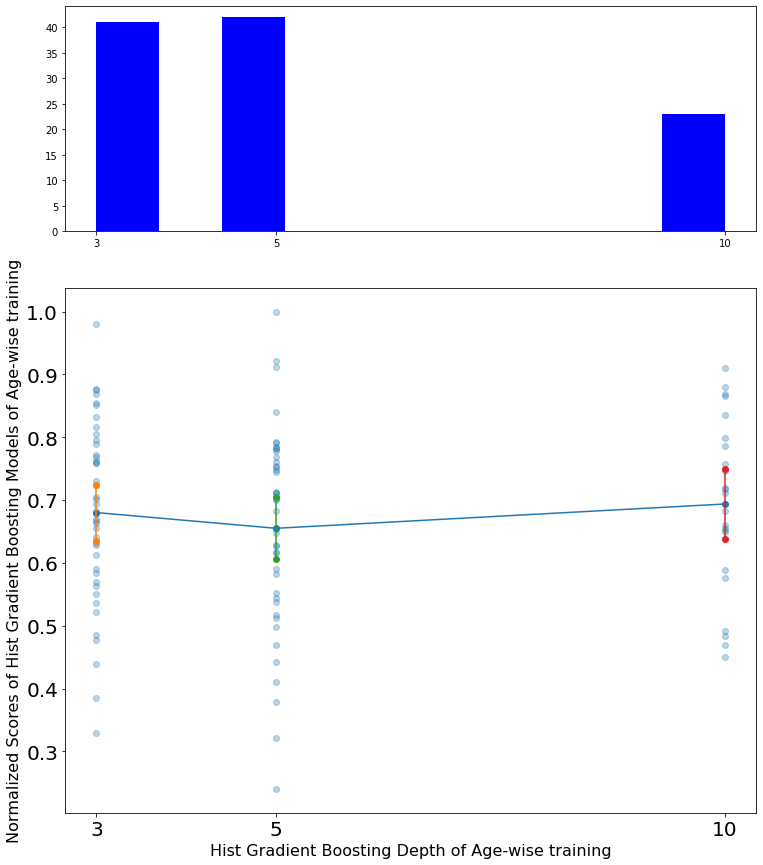

In [141]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding_age_1 = np.array(score_embedding_age) / score_embedding_age.max()
ax_0_0.scatter(depth, score_embedding_age_1, alpha=0.3)
# ax_0_0.vlines(x=3.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Depth of Age-wise training", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of Hist Gradient Boosting Models of Age-wise training", fontsize=16)

ax1_histx.hist(depth, color='blue')

depth = np.array(depth)

ax_0_0.plot(np.array([3, 5, 10]), 
        np.array([score_embedding_age_1[depth==3].mean(), score_embedding_age_1[depth==5].mean(), score_embedding_age_1[depth==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([3, 3]), 
        np.array([score_embedding_age_1[depth==3].mean()-1.96*pd.Series(score_embedding_age_1[depth==3]).sem(), score_embedding_age_1[depth==3].mean()+1.96*pd.Series(score_embedding_age_1[depth==3]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding_age_1[depth==5].mean()-1.96*pd.Series(score_embedding_age_1[depth==5]).sem(), score_embedding_age_1[depth==5].mean()+1.96*pd.Series(score_embedding_age_1[depth==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding_age_1[depth==10].mean()-1.96*pd.Series(score_embedding_age_1[depth==10]).sem(), score_embedding_age_1[depth==10].mean()+1.96*pd.Series(score_embedding_age_1[depth==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([3, 5, 10]))

fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


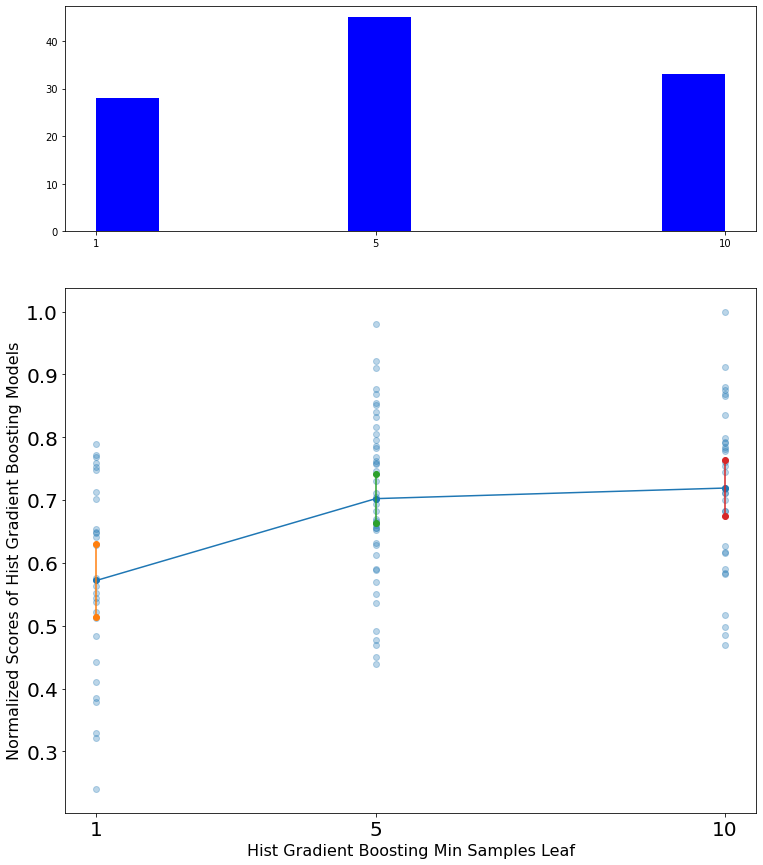

In [142]:
fig = plt.figure(figsize=(12, 14))
fig.tight_layout(pad=2.0)

gs = fig.add_gridspec(2, 1, height_ratios=(3,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.15, hspace=0.15)
ax_0_0 = fig.add_subplot(gs[1,0])

ax1_histx = fig.add_subplot(gs[0, 0], sharex=ax_0_0)
score_embedding_age_1 = np.array(score_embedding_age) / score_embedding_age.max()
ax_0_0.scatter(leaf, score_embedding_age_1, alpha=0.3)
# ax_0_0.vlines(x=18.5, ymax=1, ymin=0, linestyles='dashed', color='red')
ax_0_0.set_xlabel("Hist Gradient Boosting Min Samples Leaf", fontsize=16)
ax_0_0.set_ylabel("Normalized Scores of Hist Gradient Boosting Models", fontsize=16)

ax1_histx.hist(leaf, color='blue')

leaf = np.array(leaf)

ax_0_0.plot(np.array([1, 5, 10]), 
        np.array([score_embedding_age_1[leaf==1].mean(), score_embedding_age_1[leaf==5].mean(), score_embedding_age_1[leaf==10].mean()]), marker='o', ls='-')
ax_0_0.plot(np.array([1, 1]), 
        np.array([score_embedding_age_1[leaf==1].mean()-1.96*pd.Series(score_embedding_age_1[leaf==1]).sem(), score_embedding_age_1[leaf==1].mean()+1.96*pd.Series(score_embedding_age_1[leaf==1]).sem()]), marker='o')
ax_0_0.plot(np.array([5, 5]), 
        np.array([score_embedding_age_1[leaf==5].mean()-1.96*pd.Series(score_embedding_age_1[leaf==5]).sem(), score_embedding_age_1[leaf==5].mean()+1.96*pd.Series(score_embedding_age_1[leaf==5]).sem()]), marker='o')
ax_0_0.plot(np.array([10, 10]), 
        np.array([score_embedding_age_1[leaf==10].mean()-1.96*pd.Series(score_embedding_age_1[leaf==10]).sem(), score_embedding_age_1[leaf==10].mean()+1.96*pd.Series(score_embedding_age_1[leaf==10]).sem()]), marker='o')
ax_0_0.tick_params(labelsize=20)
ax_0_0.set_xticks(np.array([1, 5, 10]))

fig.show()

In [97]:
from copy import copy
from sklearn.metrics import accuracy_score

voting_classifier_array_copy = copy(voting_classifier_array)

accuracy = {}
recall = {}
for i in tqdm(range(len(face_classes_array_train))):
    face_classes = np.concatenate(face_classes_array_train[i:i+1])
    faces_data = np.vstack(faces_chunk_array_train[i:i+1])
    
    df = data_test[
        data_test['identity'] == face_classes[0]
    ]
    
    for k in range(len(face_classes)):
        true_positives = 0
        false_negatives = 0
        matches = 0
        count_items = 0
        accuracy_list = []
        face_classes_pred_list = []
        for j in range(len(voting_classifier_array_copy)):
            voting_classifier = voting_classifier_array_copy[j]
            faces_classes_pred = voting_classifier.predict(faces_data[k].reshape(-1,128))
            matches += (face_classes_pred == face_classes[k]).sum()
        true_positives += 0 if matches > 1 else 1
        false_negatives += 1 if matches > 1 else 0
    accuracy[face_classes[0]] = (true_positives) / (false_negatives + true_positives)
    recall[face_classes[0]] = (true_positives) / (false_negatives + true_positives)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [50:45<00:00,  9.58s/it]


In [98]:
accuracy

{'AbeVigoda': 0.0,
 'AdolfHitlerr': 1.0,
 'AlanRickman': 1.0,
 'AlecGuinness': 1.0,
 'AlejandroRey': 1.0,
 'AlexanderGrahamBell': 1.0,
 'AliMacGraw': 1.0,
 'AndreMarieAmpКre': 1.0,
 'AndyGriffith': 1.0,
 'AngelaLansbury': 1.0,
 'AngieDickinson': 1.0,
 'AnnJillian': 1.0,
 'AnnMargret': 1.0,
 'AnnMiller': 1.0,
 'AnnaMassey': 1.0,
 'AnneBancroft': 1.0,
 'AnnetteBening': 1.0,
 'AnthonyAndrews': 1.0,
 'AnthonyHopkins': 1.0,
 'AnthonyQuayle': 1.0,
 'Arletty': 1.0,
 'AvaGardner': 1.0,
 'BarbaraBain': 1.0,
 'BarbaraBouchet': 1.0,
 'BarbraStreisand': 1.0,
 'BeaArthur': 1.0,
 'BenGazzara': 1.0,
 'BernadetteLafont': 1.0,
 'BetteDavis': 1.0,
 'BetteMidler': 1.0,
 'BettyGarrett': 1.0,
 'BobDylan': 1.0,
 'BorisKarloff': 1.0,
 'BrianDennehy': 1.0,
 'BurtLancaster': 1.0,
 'BurtReynolds': 1.0,
 'CarlosSantana': 1.0,
 'Carroll': 1.0,
 'CaryGrant': 1.0,
 'CatherineDeneuve': 1.0,
 'CatherineSchell': 1.0,
 'CatherineSpaak': 1.0,
 'CharlesGrodin': 1.0,
 'CharlieChaplin': 1.0,
 'CharlieSheen': 1.0,
 'Christo

In [5]:
accuracy = {'AbeVigoda': 0.0,
 'AdolfHitlerr': 1.0,
 'AlanRickman': 1.0,
 'AlecGuinness': 1.0,
 'AlejandroRey': 1.0,
 'AlexanderGrahamBell': 1.0,
 'AliMacGraw': 1.0,
 'AndreMarieAmpКre': 1.0,
 'AndyGriffith': 1.0,
 'AngelaLansbury': 1.0,
 'AngieDickinson': 1.0,
 'AnnJillian': 1.0,
 'AnnMargret': 1.0,
 'AnnMiller': 1.0,
 'AnnaMassey': 1.0,
 'AnneBancroft': 1.0,
 'AnnetteBening': 1.0,
 'AnthonyAndrews': 1.0,
 'AnthonyHopkins': 1.0,
 'AnthonyQuayle': 1.0,
 'Arletty': 1.0,
 'AvaGardner': 1.0,
 'BarbaraBain': 1.0,
 'BarbaraBouchet': 1.0,
 'BarbraStreisand': 1.0,
 'BeaArthur': 1.0,
 'BenGazzara': 1.0,
 'BernadetteLafont': 1.0,
 'BetteDavis': 1.0,
 'BetteMidler': 1.0,
 'BettyGarrett': 1.0,
 'BobDylan': 1.0,
 'BorisKarloff': 1.0,
 'BrianDennehy': 1.0,
 'BurtLancaster': 1.0,
 'BurtReynolds': 1.0,
 'CarlosSantana': 1.0,
 'Carroll': 1.0,
 'CaryGrant': 1.0,
 'CatherineDeneuve': 1.0,
 'CatherineSchell': 1.0,
 'CatherineSpaak': 1.0,
 'CharlesGrodin': 1.0,
 'CharlieChaplin': 1.0,
 'CharlieSheen': 1.0,
 'ChristopherEccleston': 1.0,
 'ChristopherWalken': 1.0,
 'ChuckNorris': 1.0,
 'ClaudeLВviStrauss': 1.0,
 'ClaudetteColbert': 1.0,
 'CliffRobertson': 1.0,
 'ClintWalker': 1.0,
 'ConnieBooth': 1.0,
 'CydCharisse': 1.0,
 'CyndiLauper': 1.0,
 'DanaAndrews': 1.0,
 'DanielleDarrieux': 1.0,
 'DannyDeVito': 1.0,
 'DavidCarradine': 1.0,
 'DavidMcCallum': 1.0,
 'DavidSarnoff': 1.0,
 'DebbieReynolds': 1.0,
 'DebraPaget': 1.0,
 'DerekJacobi': 1.0,
 'DickieMoore': 1.0,
 'DirkBogarde': 1.0,
 'DonJohnson': 1.0,
 'DorisDay': 1.0,
 'DustinHoffman': 1.0,
 'DyanCannon': 1.0,
 'EdHarris': 1.0,
 'EdwardFox': 1.0,
 'EdwardGRobinson': 1.0,
 'EdwigeFenech': 1.0,
 'ElVenizelos': 1.0,
 'ElizabethTaylor': 1.0,
 'ElkeSommer': 1.0,
 'ElvisPresley': 1.0,
 'EnricoFermi': 1.0,
 'ErinGray': 1.0,
 'ErnestBorgnine': 1.0,
 'ErnestHemingway': 1.0,
 'ErrolFlynn': 1.0,
 'EstherWilliams': 1.0,
 'EvaMarieSaint': 1.0,
 'FayeDunaway': 1.0,
 'FernandoRey': 1.0,
 'FlemingAlex': 1.0,
 'FrancescaAnnis': 1.0,
 'FrankSinatra': 1.0,
 'FranklinDRoosevelt': 1.0,
 'FredMacMurray': 1.0,
 'FriedrichNietzsche': 1.0,
 'GabrielGarciaMarquez': 1.0,
 'Gaddafi': 1.0,
 'GaryOldman': 1.0,
 'GenaRowlands': 1.0,
 'GeneHackman': 1.0,
 'GeneWilder': 1.0,
 'GeorgeCScott': 1.0,
 'GeorgeMontgomery': 1.0,
 'GeorgePeppard': 1.0,
 'GeorgesMarchal': 1.0,
 'GeraldineChaplin': 1.0,
 'GingerRogers': 1.0,
 'GiorgosSeferis': 1.0,
 'GiulianoGemma': 1.0,
 'GladysCooper': 1.0,
 'GlendaJackson': 1.0,
 'GlennClose': 1.0,
 'GloriaSwanson': 1.0,
 'GordonThomson': 1.0,
 'GraceKelly': 1.0,
 'GreerGarson': 1.0,
 'GregoryPeck': 1.0,
 'GretaGarbo': 1.0,
 'HarrisonFord': 1.0,
 'HarveyKeitel': 1.0,
 'HedyLamarr': 1.0,
 'HelenHayes': 1.0,
 'HelenHunt': 1.0,
 'HelmutBerger': 1.0,
 'HenryFonda': 1.0,
 'HowardKeel': 1.0,
 'HumphreyBogard': 1.0,
 'IanHolm': 1.0,
 'IanMcKellen': 1.0,
 'ImeldaStaunton': 1.0,
 'IngridBergman': 1.0,
 'IreneDunne': 1.0,
 'IsabelleHuppert': 1.0,
 'JWMarriott': 1.0,
 'JackLemon': 1.0,
 'JamesArness': 1.0,
 'JamesCaan': 1.0,
 'JamesGarner': 1.0,
 'JaneAsher': 1.0,
 'JaneBirkin': 1.0,
 'JaneFonda': 1.0,
 'JanePowell': 1.0,
 'JaneRussell': 1.0,
 'JaneWyman': 1.0,
 'JanetLeigh': 1.0,
 'JeanClaudeVanDamme': 1.0,
 'JeanMarais': 1.0,
 'JeanneMoreau': 1.0,
 'JeffBridges': 1.0,
 'JeffreyJones': 1.0,
 'JenniferAniston': 1.0,
 'JenniferJones': 1.0,
 'JeremyKemp': 1.0,
 'JessicaTandy': 1.0,
 'JhonLenon': 1.0,
 'JoanLeslie': 1.0,
 'JohnGarfield': 1.0,
 'JohnHuston': 1.0,
 'JohnLithgow': 1.0,
 'JohnMalkovich': 1.0,
 'JohnTravolta': 1.0,
 'JohnWayne': 1.0,
 'JohnnyCash': 1.0,
 'JonVoight': 1.0,
 'JosephStalin': 1.0,
 'JudyGarland': 1.0,
 'JudyHolliday': 1.0,
 'JulieAdams': 1.0,
 'JulieAndrews': 1.0,
 'JuneAllyson': 1.0,
 'KatharineRoss': 1.0,
 'KathrynGrayson': 1.0,
 'KennethBranagh': 1.0,
 'KevinBacon': 1.0,
 'KevinCostner': 1.0,
 'KimNovak': 1.0,
 'KlausKinski': 1.0,
 'Konstantaras': 1.0,
 'KostasVoutsas': 1.0,
 'KrisKristofferson': 1.0,
 'KristinScottThomas': 1.0,
 'LauraAntonelli': 1.0,
 'LauraDern': 1.0,
 'LaurenBacall': 1.0,
 'LeslieCaron': 1.0,
 'LexBarker': 1.0,
 'LiamNeeson': 1.0,
 'LilliPalmer': 1.0,
 'LindaEvans': 1.0,
 'LinoVentura': 1.0,
 'LizaMinelli': 1.0,
 'LorettaYoung': 1.0,
 'LorneGreene': 1.0,
 'LuiseRainer': 1.0,
 'MarcelloMastroianni': 1.0,
 'MargaretOBrien': 1.0,
 'MargaretThatcher': 1.0,
 'MarieCurie': 1.0,
 'MarietteHartley': 1.0,
 'MarisaPavan': 1.0,
 'MarleneDietrich': 1.0,
 'MarlonBrando': 1.0,
 'MartinLutherKing': 1.0,
 'MartinScorsese': 1.0,
 'MartinSheen': 1.0,
 'MaryPickford': 1.0,
 'MaureenOHara': 1.0,
 'MegRyan': 1.0,
 'MelBrooks': 1.0,
 'MelFerrer': 1.0,
 'MelGibson': 1.0,
 'MelindaDillion': 1.0,
 'MerkouriMelina': 1.0,
 'MerylStreep': 1.0,
 'MichaelKeaton': 1.0,
 'MichaelYork': 1.0,
 'MichelPiccoli': 1.0,
 'MichellePfeiffer': 1.0,
 'MickJagger': 1.0,
 'MickeyRooney': 1.0,
 'MikeConnors': 1.0,
 'MonicaVitti': 1.0,
 'MuhammadAli': 1.0,
 'MurrayHamilton': 1.0,
 'MyrnaLoy': 1.0,
 'NelsonMandela': 1.0,
 'NewmanPaul': 1.0,
 'NickNolte': 1.0,
 'NicolasSarkozy': 1.0,
 'NielsBohr': 1.0,
 'NormaShearer': 1.0,
 'OdysseasElytis': 1.0,
 'OliviaHussey': 1.0,
 'OrnellaMuti': 1.0,
 'PabloPicasso': 1.0,
 'PatriciaNeal': 1.0,
 'PatrickStewart': 1.0,
 'PeggyAshcroft': 1.0,
 'PeggyLipton': 1.0,
 'Pele': 1.0,
 'PeterFalk': 1.0,
 'PeterGraves': 1.0,
 'PeterMarkRichman': 1.0,
 'PeterOToole': 1.0,
 'PeterUstinov': 1.0,
 'PhilHartman': 1.0,
 'PierceBrosnan': 1.0,
 'QueenElizabet': 1.0,
 'RabindranathTagore': 1.0,
 'RalphMacchio': 1.0,
 'RaquelWelch': 1.0,
 'RayLiotta': 1.0,
 'RichardBoone': 1.0,
 'RichardChamberlain': 1.0,
 'RichardPryor': 1.0,
 'RingoStarr': 1.0,
 'RitaHayworth': 1.0,
 'RobertMitchum': 1.0,
 'RobertPowell': 1.0,
 'RobertRedford': 1.0,
 'RobertRyan': 1.0,
 'RogerAllam': 1.0,
 'RomanPolanski': 1.0,
 'RonPerlman': 1.0,
 'RonaldReagan': 1.0,
 'RowanAtkinson': 1.0,
 'RutgerHauer': 1.0,
 'RyanONeal': 1.0,
 'SamElliott': 1.0,
 'SamNeill': 1.0,
 'SamuelJacksonn': 1.0,
 'SarahDouglas': 1.0,
 'ScottGlenn': 1.0,
 'ShirleyJones': 1.0,
 'SidneyPoitier': 1.0,
 'SilvanaMangano': 1.0,
 'SimonMacCorkindale': 1.0,
 'SimoneSignoret': 1.0,
 'Soljenitsyne': 1.0,
 'SophiaLoren': 1.0,
 'StacyKeach': 1.0,
 'StefaniePowers': 1.0,
 'StephenHawking': 1.0,
 'SteveJobsb': 1.0,
 'SteveMcQueen': 1.0,
 'StevenBerkoff': 1.0,
 'StevenSpielberg': 1.0,
 'SusanGeorge': 1.0,
 'SusanSarandon': 1.0,
 'SusannahYork': 1.0,
 'SylvesterStallone': 1.0,
 'TellySavalas': 1.0,
 'Thanasisveggos': 1.0,
 'TheodorakisMikis': 1.0,
 'ThomasTerry': 1.0,
 'TomHanks': 1.0,
 'TomJones': 1.0,
 'TomasMilian': 1.0,
 'TommyLeeJones': 1.0,
 'TonyBlair': 1.0,
 'TonyCurtis': 1.0,
 'Tyson': 1.0,
 'UgoTognazzi': 1.0,
 'ValerieHarper': 1.0,
 'VanessaRedgrave': 1.0,
 'VincentPrice': 1.0,
 'VirnaLisi': 1.0,
 'WEBDuBois': 1.0,
 'WarrenBeatty': 1.0,
 'WillSmith ': 1.0,
 'WilliamHolden': 1.0,
 'WilliamShatner': 1.0,
 'WoodyAllen': 1.0,
 'YvesMontand': 1.0,
 'YvonneDeCarlo': 1.0,
 'ZsaZsaGabor': 1.0,
 'angelamerkel': 1.0,
 'campbell': 1.0,
 'michaeljackson': 1.0,
 'motherTereza': 1.0}

In [13]:
pd.DataFrame(accuracy, index=['labels_test']).style.background_gradient(cmap='coolwarm')

## SHAP Explainer

In [96]:
import shap

# train XGBoost model
X,y = embeddings_test.numpy(), labels_test

model = hist_embedding_array[1].best_estimator_

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [104]:
np.unique(labels_test)

array(['AbeVigoda', 'AdolfHitlerr', 'AlanRickman', 'AlecGuinness',
       'AlejandroRey', 'AlexanderGrahamBell', 'AliMacGraw',
       'AndreMarieAmpКre', 'AndyGriffith', 'AngelaLansbury',
       'AngieDickinson', 'AnnJillian', 'AnnMargret', 'AnnMiller',
       'AnnaMassey', 'AnneBancroft', 'AnnetteBening', 'AnthonyAndrews',
       'AnthonyHopkins', 'AnthonyQuayle', 'Arletty', 'AvaGardner',
       'BarbaraBain', 'BarbaraBouchet', 'BarbraStreisand', 'BeaArthur',
       'BenGazzara', 'BernadetteLafont', 'BetteDavis', 'BetteMidler',
       'BettyGarrett', 'BobDylan', 'BorisKarloff', 'BrianDennehy',
       'BurtLancaster', 'BurtReynolds', 'CarlosSantana', 'Carroll',
       'CaryGrant', 'CatherineDeneuve', 'CatherineSchell',
       'CatherineSpaak', 'CharlesGrodin', 'CharlieChaplin',
       'CharlieSheen', 'ChristopherEccleston', 'ChristopherWalken',
       'ChuckNorris', 'ClaudeLВviStrauss', 'ClaudetteColbert',
       'CliffRobertson', 'ClintWalker', 'ConnieBooth', 'CydCharisse',
       'Cy

In [137]:
np.where([np.array(labels_test) == 'RowanAtkinson'])[1]

array([858, 859], dtype=int64)

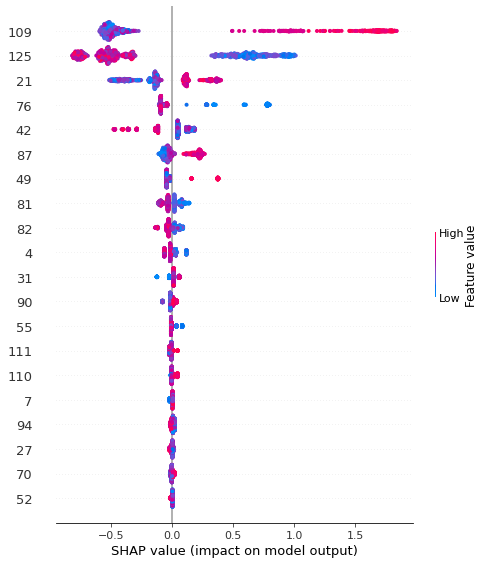

In [157]:
shap.summary_plot(shap_values[2], features=X, feature_names=list(map(lambda x: str(x), list(range(128)))))

In [ ]:
shap.partial_dependence_plot(0, explainer, X)

# Voting Ensemble 88.49% +/- 0.0017

# Age Voting Ensemble 84.61% +/- 0.0018

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

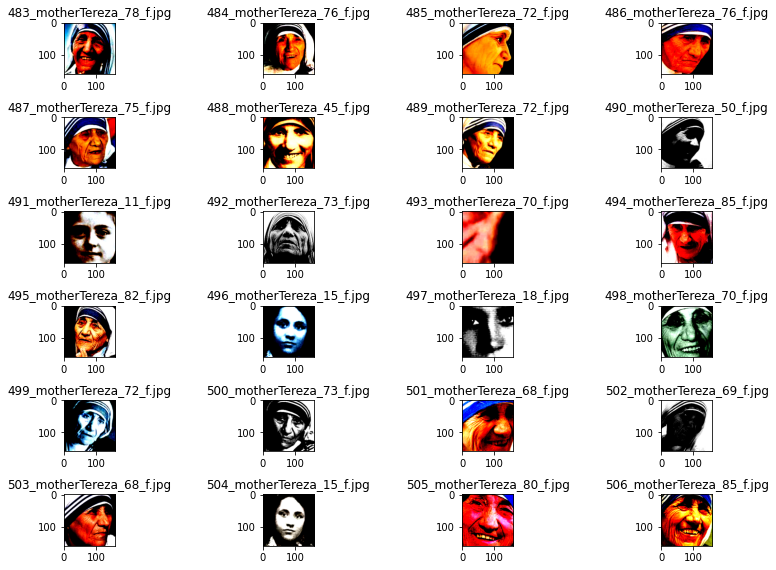

In [164]:
fig, ax = plt.subplots(6,4,figsize=(12,8))
for i in range(6):
    for j in range(4):
        ax[i,j].imshow(images[list(images.keys())[i*4+j]][0])
        ax[i,j].set_title(list(images.keys())[i*4+j])
plt.tight_layout(pad=1.0)
fig.show()

C:\Users\burse\anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: num must be 1 <= num <= 80, not 4113

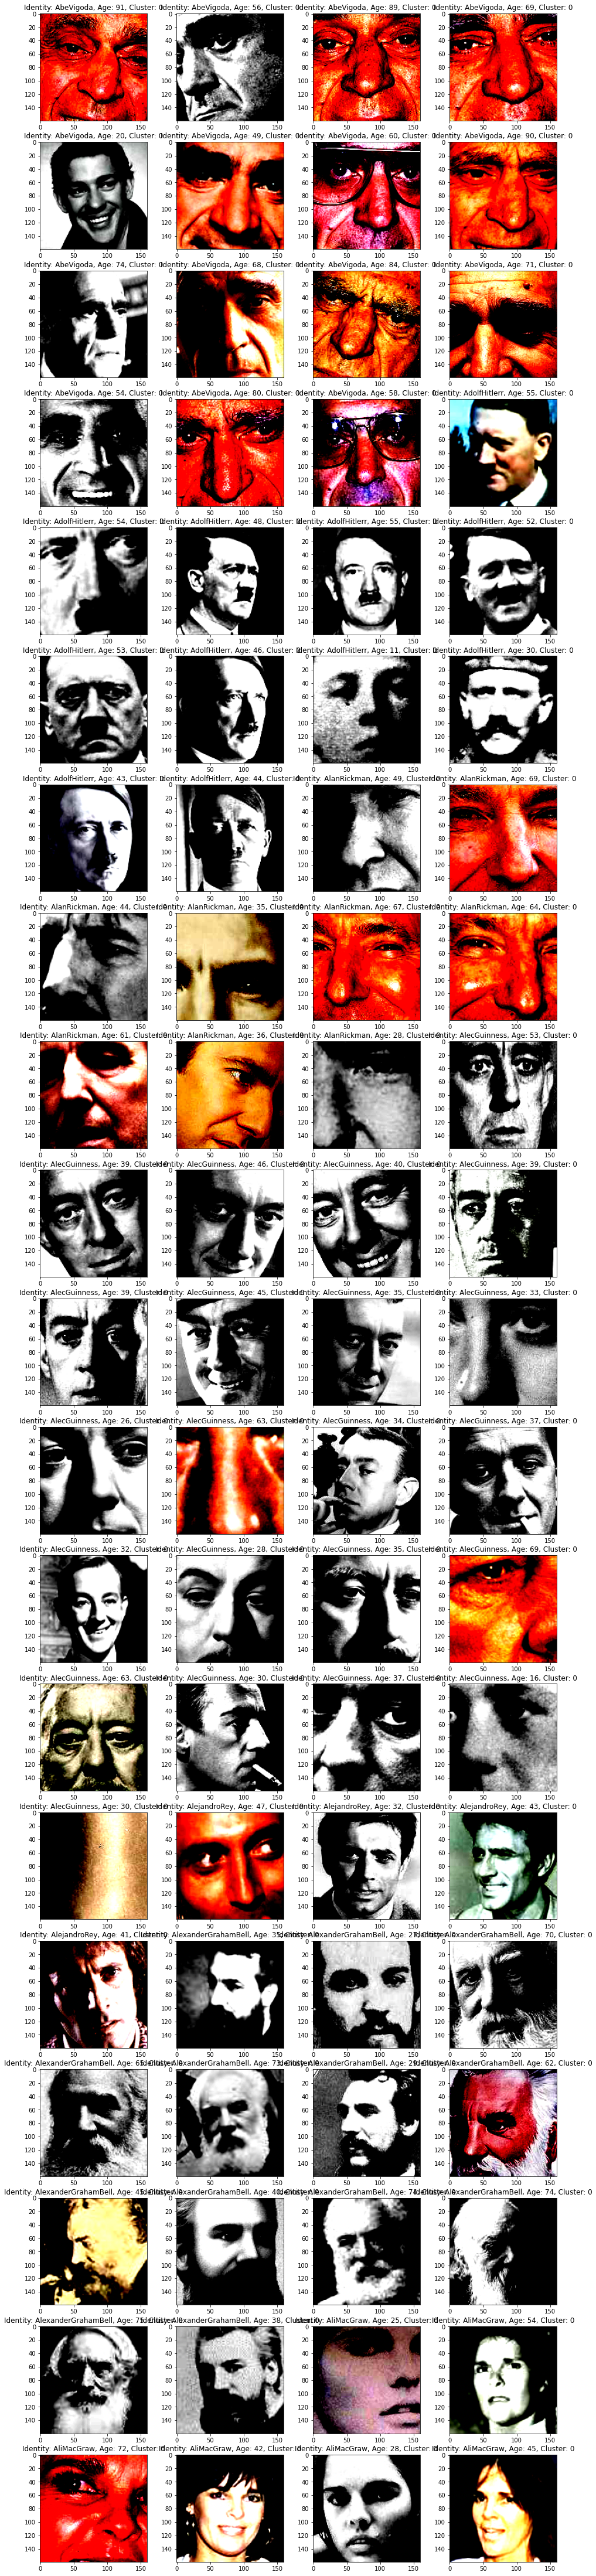

In [152]:
import os
from scipy import misc
import cv2

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image

def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = misc.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
        img = crop(img, do_random_crop, image_size)
        img = cv2.resize(img, (image_size,image_size))
        if do_prewhiten:
            img = prewhiten(img)
#         img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images

fig = plt.figure(figsize=(16,80))
plt.tight_layout(pad=2.0)
idx = -1
for ii, label in enumerate(db.labels_):
    face_ids = merge_data.loc[merge_data['cluster_label'] == label, 'face_id']
    identities = merge_data.loc[merge_data['cluster_label'] == label, 'identity']
    
    if len(face_ids) > 0:
        idx += 1
        for ij, face_id in enumerate(face_ids):
            plt.subplot(20, 4, idx*len(face_ids) + ij+1)
            res = load_data([os.path.join(DATADIR, "AgeDB", files_train[face_id])], False, False, 160)
            plt.imshow(res[0])
            plt.title("Identity: " + files_train[face_id].split("_")[1] + ", Age: " + files_train[face_id].split("_")[2] + ", Cluster: " + str(label))
            if idx*len(face_ids) + ij == 79:
                break

In [228]:
import pickle

SAVEDIR = 'D:\\DATA_HD_COMPUTER\\DATA\\Personal Data\\Aswin\'s Data\\University\\Kingston\\02. CI7000 Project Dissertation\\Dimitrios makris\\Repositories&Datasets\\face-age-verification-recognition\\notebooks\\dataset_variables_objects\\classification_clustering_agedb\\'

pickle.dump(embeddings_facenet, open(SAVEDIR + "embeddings_facenet.pkl", "wb"))
pickle.dump(files, open(SAVEDIR + "files.pkl", "wb"))
pickle.dump(labels, open(SAVEDIR + "labels.pkl", "wb"))
pickle.dump(ages, open(SAVEDIR + "ages.pkl", "wb"))
pickle.dump(merged_sample, open(SAVEDIR + "merged_sample.pkl", "wb"))
pickle.dump(svm, open(SAVEDIR + "svm.pkl", "wb"))
pickle.dump(db, open(SAVEDIR + "DBSCAN.pkl", "wb"))
pickle.dump(merge_data, open(SAVEDIR + "merge_data.pkl", "wb"))
pickle.dump(svm_grouped, open(SAVEDIR + "svm_grouped.pkl", "wb"))
pickle.dump(svm_array, open(SAVEDIR + "svm_array.pkl", "wb"))
pickle.dump(rf_array, open(SAVEDIR + "rf_array.pkl", "wb"))
pickle.dump(knn_array, open(SAVEDIR + "knn_array.pkl", "wb"))
pickle.dump(hist_array, open(SAVEDIR + "hist_array.pkl", "wb"))
pickle.dump(voting_models, open(SAVEDIR + "voting_models.pkl", "wb"))
pickle.dump(c_array, open(SAVEDIR + "c_array.pkl", "wb"))
pickle.dump(split, open(SAVEDIR + "split.pkl", "wb"))
pickle.dump(depth, open(SAVEDIR + "depth.pkl", "wb"))
pickle.dump(leaf, open(SAVEDIR + "leaf.pkl", "wb"))
pickle.dump(max_iter, open(SAVEDIR + "max_iter.pkl", "wb"))
pickle.dump(lr, open(SAVEDIR + "lr.pkl", "wb"))
pickle.dump(criterion, open(SAVEDIR + "criterion.pkl", "wb"))
pickle.dump(faces, open(SAVEDIR + "faces.pkl", "wb"))
pickle.dump(faces_test, open(SAVEDIR + "faces_test.pkl", "wb"))
pickle.dump(face_classes_array, open(SAVEDIR + "face_classes_array.pkl", "wb"))
pickle.dump(faces_test_data, open(SAVEDIR + "faces_test_data.pkl", "wb"))
pickle.dump(faces_chunk_array, open(SAVEDIR + "faces_chunk_array.pkl", "wb"))
pickle.dump(file_train_classes, open(SAVEDIR + "file_train_classes.pkl", "wb"))
pickle.dump(file_new_classes, open(SAVEDIR + "file_new_classes.pkl", "wb"))
pickle.dump(files_valid, open(SAVEDIR + "files_valid.pkl", "wb"))
pickle.dump(full_cluster_label_0, open(SAVEDIR + "full_cluster_label_0.pkl", "wb"))

pickle.dump(score_embedding, open(SAVEDIR + "/score_embedding.pkl", "wb"))
pickle.dump(voting_classifier_array, open(SAVEDIR + "/voting_classifier_array.pkl", "wb"))
pickle.dump(svm_embedding_array, open(SAVEDIR + "/svm_embedding_array.pkl", "wb"))
pickle.dump(rf_embedding_array, open(SAVEDIR + "/rf_embedding_array.pkl", "wb"))
pickle.dump(hist_embedding_array, open(SAVEDIR + "/hist_embedding_array.pkl", "wb"))
pickle.dump(knn_embeding_array, open(SAVEDIR + "/knn_embeding_array.pkl", "wb"))

In [4]:
import pickle

SAVEDIR = 'D:\\DATA_HD_COMPUTER\\DATA\\Personal Data\\Aswin\'s Data\\University\\Kingston\\02. CI7000 Project Dissertation\\Dimitrios makris\\Repositories_Datasets\\face-age-verification-recognition\\notebooks\\dataset_variables_objects\\classification_clustering_agedb\\'

embeddings_facenet = pickle.load(open(SAVEDIR + "embeddings_facenet.pkl", "rb"))
images_dict = pickle.load(open(SAVEDIR + "images_dict.pkl", "rb"))
files = pickle.load(open(SAVEDIR + "files.pkl", "rb"))
labels = pickle.load(open(SAVEDIR + "labels.pkl", "rb"))
ages = pickle.load(open(SAVEDIR + "ages.pkl", "rb"))
merged_sample = pickle.load(open(SAVEDIR + "merged_sample.pkl", "rb"))
svm = pickle.load(open(SAVEDIR + "svm.pkl", "rb"))
db = pickle.load(open(SAVEDIR + "DBSCAN.pkl", "rb"))
merge_data = pickle.load(open(SAVEDIR + "merge_data.pkl", "rb"))
svm_grouped = pickle.load(open(SAVEDIR + "svm_grouped.pkl", "rb"))
svm_array = pickle.load(open(SAVEDIR + "svm_array.pkl", "rb"))
rf_array = pickle.load(open(SAVEDIR + "rf_array.pkl", "rb"))
knn_array = pickle.load(open(SAVEDIR + "knn_array.pkl", "rb"))
hist_array = pickle.load(open(SAVEDIR + "hist_array.pkl", "rb"))
voting_models = pickle.load(open(SAVEDIR + "voting_models.pkl", "rb"))
c_array = pickle.load(open(SAVEDIR + "c_array.pkl", "rb"))
split = pickle.load(open(SAVEDIR + "split.pkl", "rb"))
depth = pickle.load(open(SAVEDIR + "depth.pkl", "rb"))
leaf = pickle.load(open(SAVEDIR + "leaf.pkl", "rb"))
max_iter = pickle.load(open(SAVEDIR + "max_iter.pkl", "rb"))
lr = pickle.load(open(SAVEDIR + "lr.pkl", "rb"))
criterion = pickle.load(open(SAVEDIR + "criterion.pkl", "rb"))
faces = pickle.load(open(SAVEDIR + "faces.pkl", "rb"))
faces_test = pickle.load(open(SAVEDIR + "faces_test.pkl", "rb"))
face_classes_array = pickle.load(open(SAVEDIR + "face_classes_array.pkl", "rb"))
faces_test_data = pickle.load(open(SAVEDIR + "faces_test_data.pkl", "rb"))
faces_chunk_array = pickle.load(open(SAVEDIR + "faces_chunk_array.pkl", "rb"))
file_train_classes = pickle.load(open(SAVEDIR + "file_train_classes.pkl", "rb"))
file_new_classes = pickle.load(open(SAVEDIR + "file_new_classes.pkl", "rb"))
files_valid = pickle.load(open(SAVEDIR + "files_valid.pkl", "rb"))
full_cluster_label_0 = pickle.load(open(SAVEDIR + "full_cluster_label_0.pkl", "rb"))
voting_classifier_array = pickle.load(open(SAVEDIR + "/voting_classifier_array.pkl", "rb"))
score_embedding = pickle.load(open(SAVEDIR + "/score_embedding.pkl", "rb"))
svm_embedding_array = pickle.load(open(SAVEDIR + "/svm_embedding_array.pkl", "rb"))
rf_embedding_array = pickle.load(open(SAVEDIR + "/rf_embedding_array.pkl", "rb"))
hist_embedding_array = pickle.load(open(SAVEDIR + "/hist_embedding_array.pkl", "rb"))
knn_embeding_array = pickle.load(open(SAVEDIR + "/knn_embedding_array.pkl", "rb"))

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'C:\\Users\\burse\\AppData\\Roaming\\Python\\Python37\\site-packages\\pandas\\core\\internals\\blocks.py'>

In [14]:
import pandas as pd
import numpy as np

cat = dict(zip(list(range(6400)), ['cat', 'dog', 'mouse', 'deer']*1600))

np.random.seed(1000)
data = pd.DataFrame(dict(i=np.arange(0,6400), r=np.random.randn(6400), c=[cat[i] for i in range(6400)]))

In [28]:
np.random.seed(1000)
data.sample(10)

i         r      c
683    683  1.894870   deer
5003  5003  0.879336   deer
895    895 -0.675412   deer
2497  2497  0.230317    dog
822    822  0.068141  mouse
5763  5763 -0.328301   deer
896    896 -1.187665    cat
4147  4147  0.843877   deer
4286  4286  0.744568  mouse
1277  1277 -0.726565    dog

In [29]:
np.random.seed(1000)
data.sample(20)

i         r      c
683    683  1.894870   deer
5003  5003  0.879336   deer
895    895 -0.675412   deer
2497  2497  0.230317    dog
822    822  0.068141  mouse
5763  5763 -0.328301   deer
896    896 -1.187665    cat
4147  4147  0.843877   deer
4286  4286  0.744568  mouse
1277  1277 -0.726565    dog
3941  3941  0.417232    dog
1474  1474  0.053019  mouse
4862  4862  1.862839  mouse
5377  5377 -0.219358    dog
4363  4363  0.834494   deer
3787  3787 -1.063356   deer
4742  4742 -0.026221  mouse
403    403  0.531191   deer
1317  1317 -2.389675    dog
5166  5166  0.027341  mouse

In [56]:
import pandas as pd

matches = pd.read_csv("matches.csv")
matches

name  age gender                       filename  \
0      AlbertoSordi   45      m     7764_AlbertoSordi_45_m.jpg   
1      AlbertoSordi   50      m     7766_AlbertoSordi_50_m.jpg   
2      AlbertoSordi   76      m     7779_AlbertoSordi_76_m.jpg   
3    AngelaLansbury   20      f  11948_AngelaLansbury_20_f.jpg   
4    AngelaLansbury   35      f  11959_AngelaLansbury_35_f.jpg   
..              ...  ...    ...                            ...   
234        TomJones   69      f         9783_TomJones_69_f.jpg   
235    WarrenBeatty   23      m     4993_WarrenBeatty_23_m.jpg   
236    WarrenBeatty   42      m     5028_WarrenBeatty_42_m.jpg   
237    WarrenBeatty   57      m     5009_WarrenBeatty_57_m.jpg   
238    WarrenBeatty   75      m     5023_WarrenBeatty_75_m.jpg   

     age_drift_source_iter1  stat_TP  stat_FP   true_identity  age.1  \
0                         1        1        0    AlbertoSordi     76   
1                         1        1        0    AlbertoSordi     50   
2                         1        1        0    AlbertoSordi     45   
3                         1        0        1  AngelaLansbury     20   
4                         1        0        1  AngelaLansbury     80   
..                      ...      ...      ...             ...    ...   
234                       1        0        1        TomJones     64   
235                       0        0        1    WarrenBeatty     75   
236                       0        0        1    WarrenBeatty     23   
237                       1        0        0    WarrenBeatty     42   
238                       1        0        0    WarrenBeatty     57   

                        filename.1  stat_TP.1  
0       7779_AlbertoSordi_76_m.jpg          1  
1       7766_AlbertoSordi_50_m.jpg          1  
2       7764_AlbertoSordi_45_m.jpg          1  
3    11948_AngelaLansbury_20_f.jpg          0  
4    11984_AngelaLansbury_80_f.jpg          0  
..                             ...        ...  
234         1857_TomJones_64_m.jpg          0  
235     5023_WarrenBeatty_75_m.jpg          0  
236     4993_WarrenBeatty_23_m.jpg          0  
237     5028_WarrenBeatty_42_m.jpg          0  
238     5009_WarrenBeatty_57_m.jpg          0  

[239 rows x 11 columns]

In [9]:
matches.isna().sum()

name                      0
age                       0
gender                    0
filename                  0
age_drift_source_iter1    0
stat_TP                   0
stat_FP                   0
true_identity             0
age.1                     0
filename.1                0
dtype: int64

In [24]:
import matplotlib.pyplot as plt

## Age drifting Model with 85% accuracy

### If the values after eliminating age factor has different answers, then the one which is unequal shows the drift

In [98]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

matches = pd.read_csv("matches.csv")
print(accuracy_score(matches['age_drift_source_iter1'], matches['stat_FP_offset_2000']))
print(accuracy_score(matches['age_drift_source_iter1'], matches['stat_FP_offset_100']))
print(accuracy_score(matches['age_drift_source_iter1'], matches['stat_FP_offset_100_w_10']))
print(accuracy_score(matches['age_drift_source_iter1'], matches['stat_FP_offset_0.01_w_10']))

print(accuracy_score(matches['orig_TP_regular'], matches['stat_FP_offset_2000']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_offset_100']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_offset_100_w_10']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_beta']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_beta_1000']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_Kernel_RBF']))
print(accuracy_score(matches['orig_TP_new'], matches['stat_FP_Kernel_RBF_Minus_Image']))

0.5397489539748954
0.5397489539748954
0.5397489539748954
0.5397489539748954
0.6443514644351465
0.5774058577405857
0.5774058577405857
0.5774058577405857
0.5774058577405857
0.6401673640167364
0.6652719665271967


In [103]:
import numpy as np

np.histogram(np.random.normal(size=100))

(array([ 1,  3, 11, 14, 27, 25,  9,  8,  1,  1], dtype=int64),
 array([-2.26657244, -1.74991821, -1.23326397, -0.71660974, -0.19995551,
         0.31669873,  0.83335296,  1.35000719,  1.86666143,  2.38331566,
         2.89996989]))

In [3]:
import pandas as pd

sample_results_0 = pd.read_csv("../../Face_Aging_Concept_Drift/src/data_collection/drift_synthesis_filename_kernelpca_poly.csv", index_col=0)

In [4]:
sample_results_0

hash_sample  offset   true_identity  age                       filename  \
200          201     100    AlbertoSordi   45     7764_AlbertoSordi_45_m.jpg   
201          202     100    AlbertoSordi   50     7766_AlbertoSordi_50_m.jpg   
202          203     100    AlbertoSordi   76     7779_AlbertoSordi_76_m.jpg   
21            22     100  AngelaLansbury   20  11948_AngelaLansbury_20_f.jpg   
22            23     100  AngelaLansbury   35  11959_AngelaLansbury_35_f.jpg   
..           ...     ...             ...  ...                            ...   
237          238     100        TomJones   69         9783_TomJones_69_f.jpg   
149          150     100    WarrenBeatty   23     4993_WarrenBeatty_23_m.jpg   
150          151     100    WarrenBeatty   57     5009_WarrenBeatty_57_m.jpg   
151          152     100    WarrenBeatty   75     5023_WarrenBeatty_75_m.jpg   
152          153     100    WarrenBeatty   42     5028_WarrenBeatty_42_m.jpg   

             y_pred         y_drift  predicted_age  euclidean    cosine  \
200    AlbertoSordi    AlbertoSordi          99.36  17.547852  0.072891   
201    AlbertoSordi    AlbertoSordi         101.02  15.022687  0.079527   
202    AlbertoSordi    AlbertoSordi          98.76  22.491486  0.023994   
21   AngelaLansbury    MickeyRooney          99.01  20.836079  0.107432   
22   AngelaLansbury    MickeyRooney         101.01  20.706863  0.035907   
..              ...             ...            ...        ...       ...   
237        TomJones  AnthonyHopkins         100.00  22.081146  0.146431   
149    WarrenBeatty       PeterFalk         101.18  19.266329  0.022215   
150              -1              -1         100.69  12.622162  0.189772   
151    WarrenBeatty       PeterFalk          99.00  21.887791  0.056234   
152              -1              -1         101.02  19.425673  0.025974   

     identity_grouping_distance  orig_TP  orig_FN  virtual_TP  virtual_FN  \
200                  -85.784748        1        0           1           0   
201                 -271.150001        1        0           1           0   
202                -2460.908926        1        0           1           0   
21                 -2763.389616        1        0           0           1   
22                 -1311.032408        1        0           0           1   
..                          ...      ...      ...         ...         ...   
237                    0.000009        1        0           0           1   
149                 -144.370099        1        0           0           1   
150                  706.328302        0        1           0           1   
151                -1021.955066        1        0           0           1   
152                 -112.730299        0        1           0           1   

     stat_TP  stat_FP  stat_undefined  
200        1        0               0  
201        1        0               0  
202        1        0               0  
21         0        1               0  
22         0        1               0  
..       ...      ...             ...  
237        0        1               0  
149        0        1               0  
150        0        0               1  
151        0        1               0  
152        0        0               1  

[239 rows x 18 columns]

In [126]:
import pickle

pca = pickle.load(open("agedb_pca_covariates_pca.pkl", "rb"))

In [132]:
(pca.components_.T.dot(np.random.randint(0, 255, size=(239, 2041)))).sum(axis=1)

array([ 164264.35432738,  403767.1323612 ,   76427.61021368,
       -440533.37551066,  305246.53925859,  365696.78819744,
         50048.78724363,  452478.86681085, -257902.97781494,
       -561482.6378769 ,  -68809.84608629,  562549.48045518,
         41506.61791893,  103627.69403508, -286636.22723686,
       -311552.34446306,  273364.82290106,   -4474.19711165,
        353361.54888812,   96300.47520257,   79297.84487042,
        109642.40134978,  -51884.54937865, -149550.37527993,
       -129382.88481979, -166462.41900479,  156507.85679253,
         38539.27651284,  266195.79449108,   -4196.44996031,
       -143879.38218584,    6027.11435099,  463327.92393139,
        353238.78536813,  180669.26432867,   87014.11841949,
       -106265.49361991,  -23069.89199909, -188944.92112058,
        198340.04341173,  183561.88885742, -139303.50135036,
       -812323.27042631, -188199.55537095, -122122.52306896,
       -126545.5942094 ,  -61243.76598884,   32282.6420998 ,
        -91824.62671792,

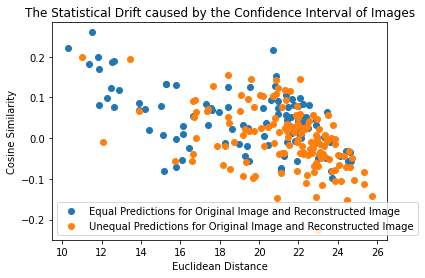

In [6]:
import matplotlib.pyplot as plt

plt.scatter(sample_results_0['euclidean'][sample_results_0['stat_FP']==0], sample_results_0['cosine'][sample_results_0['stat_FP']==0], label='Equal Predictions for Original Image and Reconstructed Image')
plt.scatter(sample_results_0['euclidean'][sample_results_0['stat_FP']==1], sample_results_0['cosine'][sample_results_0['stat_FP']==1], label='Unequal Predictions for Original Image and Reconstructed Image')
plt.xlabel("Euclidean Distance")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.title("The Statistical Drift caused by the Confidence Interval of Images")
plt.show()

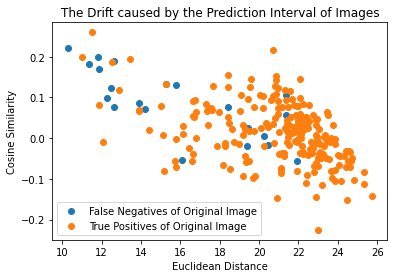

In [7]:
plt.scatter(sample_results_0['euclidean'][sample_results_0['orig_TP']==0], sample_results_0['cosine'][sample_results_0['orig_TP']==0], label='False Negatives of Original Image')
plt.scatter(sample_results_0['euclidean'][sample_results_0['orig_TP']==1], sample_results_0['cosine'][sample_results_0['orig_TP']==1], label='True Positives of Original Image')
plt.xlabel("Euclidean Distance")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.title("The Drift caused by the Prediction Interval of Images")
plt.show()

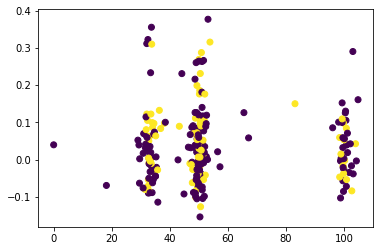

In [146]:
plt.scatter(sample_results_0['predicted_age'], sample_results_0['cosine'], c=sample_results_0['stat_TP'])

[9.99732649e-01 2.60151309e-04]


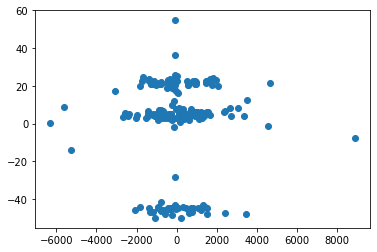

In [124]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(sample_results_0[['predicted_age', 'cosine', 'euclidean', 'identity_grouping_distance']])
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  2.,  3.,  5.,  1.,  3.,  1.,  3.,  3.,  4.,
         6.,  4.,  8.,  4.,  5.,  7.,  5.,  7.,  2.,  4.,  5.,  3.,  5.,
         9.,  7.,  3.,  9.,  4., 14.,  2.,  9.,  6.,  2., 10.,  6., 10.,
         4.,  4.,  6.,  1.,  4.,  5.,  1.,  1.,  0.,  1.,  1.,  2.,  0.,
         2.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

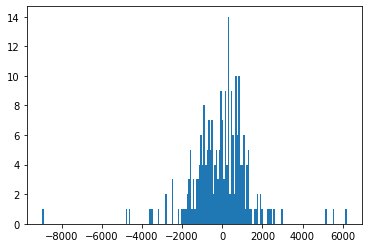

In [119]:
plt.hist(sample_results_0['identity_grouping_distance'])

In [53]:
sample_results = pd.read_csv("sample_results.csv", index_col=0)
sample_results

hash_sample  offset   true_identity  age                       filename  \
0            1.0     100     LuiseRainer   26     10638_LuiseRainer_26_f.jpg   
1            1.0     100     OrnellaMuti   26     10762_OrnellaMuti_26_f.jpg   
2            2.0     100       JonVoight   60        2073_JonVoight_60_m.jpg   
3            2.0     100      MickJagger   66       2794_MickJagger_66_m.jpg   
4            3.0     100  BarbaraBouchet   25  11847_BarbaraBouchet_25_f.jpg   
..           ...     ...             ...  ...                            ...   
234        161.0     100    MireilleDarc   58    11683_MireilleDarc_58_f.jpg   
235        162.0     100     LuiseRainer   28     10666_LuiseRainer_28_f.jpg   
236        162.0     100      HelenHayes   78      13550_HelenHayes_78_f.jpg   
237        165.0     100     LuiseRainer   27     10645_LuiseRainer_27_f.jpg   
238        165.0     100    MireilleDarc   38    11669_MireilleDarc_38_f.jpg   

          pred_orig         pred_virtual  predicted_age  euclidean    cosine  \
0       LuiseRainer           HerbertLom          31.58  16.884315  0.126358   
1       OrnellaMuti             PaulAnka          30.97  22.780375 -0.044597   
2         JonVoight            JonVoight          44.29  21.688602  0.089635   
3        MickJagger            EdwardFox          57.12  23.307009 -0.019550   
4    BarbaraBouchet       BarbaraBouchet          93.31  21.432491  0.042542   
..              ...                  ...            ...        ...       ...   
234    MireilleDarc  MarcelloMastroianni          53.75  21.426184 -0.028135   
235     LuiseRainer           HerbertLom          31.98  19.088440  0.058320   
236      HelenHayes           HelenHayes          37.53  17.056282  0.132576   
237              -1                   -1          29.39  12.728569  0.096699   
238    MireilleDarc    ChristopherWalken          45.96  12.993464  0.231543   

     identity_grouping_distance  orig_TP  orig_FN  virtual_TN  virtual_FP  \
0                  -8968.366364        1        0           0           1   
1                  -4743.828646        1        0           0           1   
2                  -3601.091190        1        0           1           0   
3                  -4646.090347        1        0           0           1   
4                  -3535.987731        1        0           1           0   
..                          ...      ...      ...         ...         ...   
234                 2596.677842        1        0           0           1   
235                 5154.595496        1        0           0           1   
236                 3000.229443        1        0           1           0   
237                 6192.497152        0        1           0           1   
238                 5537.540523        1        0           0           1   

     stat_TP  stat_FP  stat_undefined  
0          0        1               0  
1          0        1               0  
2          1        0               0  
3          0        1               0  
4          1        0               0  
..       ...      ...             ...  
234        0        1               0  
235        0        1               0  
236        1        0               0  
237        0        0               1  
238        0        1               0  

[239 rows x 18 columns]

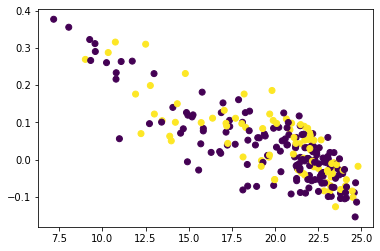

In [54]:
plt.scatter(sample_results['euclidean'], sample_results['cosine'], c=sample_results['stat_TP'])

In [59]:
accuracy_score(matches['age_drift_source_iter1'], matches['stat_TP.1'])

0.4309623430962343